In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install -r /content/drive/MyDrive/dataset_brats/requirements.txt

In [3]:
import argparse
import logging
import math
import os
import random
import sys
import time
from copy import deepcopy
from datetime import datetime
from functools import partial
from importlib import import_module
from itertools import product
from typing import Any, Dict, Generator, ItemsView, List, Optional, Tuple, Type

import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.loss import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.ops.boxes import batched_nms, box_area
from torchvision.transforms.functional import resize, to_pil_image
from tqdm import tqdm
from icecream import ic


In [4]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.



class PromptEncoder(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        image_embedding_size: Tuple[int, int],
        input_image_size: Tuple[int, int],
        mask_in_chans: int,
        activation: Type[nn.Module] = nn.GELU,
    ) -> None:
        """
        Encodes prompts for input to SAM's mask decoder.

        Arguments:
          embed_dim (int): The prompts' embedding dimension
          image_embedding_size (tuple(int, int)): The spatial size of the
            image embedding, as (H, W).
          input_image_size (int): The padded size of the image as input
            to the image encoder, as (H, W).
          mask_in_chans (int): The number of hidden channels used for
            encoding input masks.
          activation (nn.Module): The activation to use when encoding
            input masks.
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.input_image_size = input_image_size
        self.image_embedding_size = image_embedding_size
        self.pe_layer = PositionEmbeddingRandom(embed_dim // 2)

        self.num_point_embeddings: int = 4  # pos/neg point + 2 box corners
        point_embeddings = [nn.Embedding(1, embed_dim) for i in range(self.num_point_embeddings)]
        self.point_embeddings = nn.ModuleList(point_embeddings)
        self.not_a_point_embed = nn.Embedding(1, embed_dim)

        self.mask_input_size = (4 * image_embedding_size[0], 4 * image_embedding_size[1])
        self.mask_downscaling = nn.Sequential(
            nn.Conv2d(1, mask_in_chans // 4, kernel_size=2, stride=2),
            LayerNorm2d(mask_in_chans // 4),
            activation(),
            nn.Conv2d(mask_in_chans // 4, mask_in_chans, kernel_size=2, stride=2),
            LayerNorm2d(mask_in_chans),
            activation(),
            nn.Conv2d(mask_in_chans, embed_dim, kernel_size=1),
        )  # downsample to 1/4
        self.no_mask_embed = nn.Embedding(1, embed_dim)

    def get_dense_pe(self) -> torch.Tensor:
        """
        Returns the positional encoding used to encode point prompts,
        applied to a dense set of points the shape of the image encoding.

        Returns:
          torch.Tensor: Positional encoding with shape
            1x(embed_dim)x(embedding_h)x(embedding_w)
        """
        return self.pe_layer(self.image_embedding_size).unsqueeze(0)

    def _embed_points(
        self,
        points: torch.Tensor,
        labels: torch.Tensor,
        pad: bool,
    ) -> torch.Tensor:
        """Embeds point prompts."""
        points = points + 0.5  # Shift to center of pixel
        if pad:
            padding_point = torch.zeros((points.shape[0], 1, 2), device=points.device)
            padding_label = -torch.ones((labels.shape[0], 1), device=labels.device)
            points = torch.cat([points, padding_point], dim=1)
            labels = torch.cat([labels, padding_label], dim=1)
        point_embedding = self.pe_layer.forward_with_coords(points, self.input_image_size)
        point_embedding[labels == -1] = 0.0
        point_embedding[labels == -1] += self.not_a_point_embed.weight
        point_embedding[labels == 0] += self.point_embeddings[0].weight
        point_embedding[labels == 1] += self.point_embeddings[1].weight
        return point_embedding

    def _embed_boxes(self, boxes: torch.Tensor) -> torch.Tensor:
        """Embeds box prompts."""
        boxes = boxes + 0.5  # Shift to center of pixel
        coords = boxes.reshape(-1, 2, 2)
        corner_embedding = self.pe_layer.forward_with_coords(coords, self.input_image_size)
        corner_embedding[:, 0, :] += self.point_embeddings[2].weight
        corner_embedding[:, 1, :] += self.point_embeddings[3].weight
        return corner_embedding

    def _embed_masks(self, masks: torch.Tensor) -> torch.Tensor:
        """Embeds mask inputs."""
        mask_embedding = self.mask_downscaling(masks)
        return mask_embedding

    def _get_batch_size(
        self,
        points: Optional[Tuple[torch.Tensor, torch.Tensor]],
        boxes: Optional[torch.Tensor],
        masks: Optional[torch.Tensor],
    ) -> int:
        """
        Gets the batch size of the output given the batch size of the input prompts.
        """
        if points is not None:
            return points[0].shape[0]
        elif boxes is not None:
            return boxes.shape[0]
        elif masks is not None:
            return masks.shape[0]
        else:
            return 1

    def _get_device(self) -> torch.device:
        return self.point_embeddings[0].weight.device

    def forward(
        self,
        points: Optional[Tuple[torch.Tensor, torch.Tensor]],
        boxes: Optional[torch.Tensor],
        masks: Optional[torch.Tensor],
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Embeds different types of prompts, returning both sparse and dense
        embeddings.

        Arguments:
          points (tuple(torch.Tensor, torch.Tensor) or none): point coordinates
            and labels to embed.
          boxes (torch.Tensor or none): boxes to embed
          masks (torch.Tensor or none): masks to embed

        Returns:
          torch.Tensor: sparse embeddings for the points and boxes, with shape
            BxNx(embed_dim), where N is determined by the number of input points
            and boxes.
          torch.Tensor: dense embeddings for the masks, in the shape
            Bx(embed_dim)x(embed_H)x(embed_W)
        """
        bs = self._get_batch_size(points, boxes, masks)
        sparse_embeddings = torch.empty((bs, 0, self.embed_dim), device=self._get_device())
        if points is not None:
            coords, labels = points
            point_embeddings = self._embed_points(coords, labels, pad=(boxes is None))
            sparse_embeddings = torch.cat([sparse_embeddings, point_embeddings], dim=1)
        if boxes is not None:
            box_embeddings = self._embed_boxes(boxes)
            sparse_embeddings = torch.cat([sparse_embeddings, box_embeddings], dim=1)

        if masks is not None:
            dense_embeddings = self._embed_masks(masks)
        else:
            dense_embeddings = self.no_mask_embed.weight.reshape(1, -1, 1, 1).expand(
                bs, -1, self.image_embedding_size[0], self.image_embedding_size[1]
            )

        return sparse_embeddings, dense_embeddings


class PositionEmbeddingRandom(nn.Module):
    """
    Positional encoding using random spatial frequencies.
    """

    def __init__(self, num_pos_feats: int = 64, scale: Optional[float] = None) -> None:
        super().__init__()
        if scale is None or scale <= 0.0:
            scale = 1.0
        self.register_buffer(
            "positional_encoding_gaussian_matrix",
            scale * torch.randn((2, num_pos_feats)),
        )

    def _pe_encoding(self, coords: torch.Tensor) -> torch.Tensor:
        """Positionally encode points that are normalized to [0,1]."""
        # assuming coords are in [0, 1]^2 square and have d_1 x ... x d_n x 2 shape
        coords = 2 * coords - 1
        coords = coords @ self.positional_encoding_gaussian_matrix
        coords = 2 * np.pi * coords
        # outputs d_1 x ... x d_n x C shape
        return torch.cat([torch.sin(coords), torch.cos(coords)], dim=-1)

    def forward(self, size: Tuple[int, int]) -> torch.Tensor:
        """Generate positional encoding for a grid of the specified size."""
        h, w = size
        device: Any = self.positional_encoding_gaussian_matrix.device
        grid = torch.ones((h, w), device=device, dtype=torch.float32)
        y_embed = grid.cumsum(dim=0) - 0.5
        x_embed = grid.cumsum(dim=1) - 0.5
        y_embed = y_embed / h
        x_embed = x_embed / w

        pe = self._pe_encoding(torch.stack([x_embed, y_embed], dim=-1))
        return pe.permute(2, 0, 1)  # C x H x W

    def forward_with_coords(
        self, coords_input: torch.Tensor, image_size: Tuple[int, int]
    ) -> torch.Tensor:
        """Positionally encode points that are not normalized to [0,1]."""
        coords = coords_input.clone()
        coords[:, :, 0] = coords[:, :, 0] / image_size[1]
        coords[:, :, 1] = coords[:, :, 1] / image_size[0]
        return self._pe_encoding(coords.to(torch.float))  # B x N x C


In [5]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import torch
import torch.nn as nn
import torch.nn.functional as F
from icecream import ic

from typing import Optional, Tuple, Type

# from .common import LayerNorm2d, MLPBlock


# This class and its supporting functions below lightly adapted from the ViTDet backbone available at: https://github.com/facebookresearch/detectron2/blob/main/detectron2/modeling/backbone/vit.py # noqa
class ImageEncoderViT(nn.Module):
    def __init__(
        self,
        img_size: int = 1024,
        patch_size: int = 16,
        in_chans: int = 3,
        embed_dim: int = 768,
        depth: int = 12,
        num_heads: int = 12,
        mlp_ratio: float = 4.0,
        out_chans: int = 256,
        qkv_bias: bool = True,
        norm_layer: Type[nn.Module] = nn.LayerNorm,
        act_layer: Type[nn.Module] = nn.GELU,
        use_abs_pos: bool = True,
        use_rel_pos: bool = False,
        rel_pos_zero_init: bool = True,
        window_size: int = 0,
        global_attn_indexes: Tuple[int, ...] = (),
    ) -> None:
        """
        Args:
            img_size (int): Input image size.
            patch_size (int): Patch size.
            in_chans (int): Number of input image channels.
            embed_dim (int): Patch embedding dimension.
            depth (int): Depth of ViT.
            num_heads (int): Number of attention heads in each ViT block.
            mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
            qkv_bias (bool): If True, add a learnable bias to query, key, value.
            norm_layer (nn.Module): Normalization layer.
            act_layer (nn.Module): Activation layer.
            use_abs_pos (bool): If True, use absolute positional embeddings.
            use_rel_pos (bool): If True, add relative positional embeddings to the attention map.
            rel_pos_zero_init (bool): If True, zero initialize relative positional parameters.
            window_size (int): Window size for window attention blocks.
            global_attn_indexes (list): Indexes for blocks using global attention.
        """
        super().__init__()
        self.img_size = img_size

        self.patch_embed = PatchEmbed(
            kernel_size=(patch_size, patch_size),
            stride=(patch_size, patch_size),
            in_chans=in_chans,
            embed_dim=embed_dim,
        )

        self.pos_embed: Optional[nn.Parameter] = None
        if use_abs_pos:
            # Initialize absolute positional embedding with pretrain image size.
            self.pos_embed = nn.Parameter(
                torch.zeros(1, img_size // patch_size, img_size // patch_size, embed_dim)
            )

        self.blocks = nn.ModuleList()
        for i in range(depth):
            block = Block(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                norm_layer=norm_layer,
                act_layer=act_layer,
                use_rel_pos=use_rel_pos,
                rel_pos_zero_init=rel_pos_zero_init,
                window_size=window_size if i not in global_attn_indexes else 0,
                input_size=(img_size // patch_size, img_size // patch_size),
            )
            self.blocks.append(block)

        self.neck = nn.Sequential(
            nn.Conv2d(
                embed_dim,
                out_chans,
                kernel_size=1,
                bias=False,
            ),
            LayerNorm2d(out_chans),
            nn.Conv2d(
                out_chans,
                out_chans,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            LayerNorm2d(out_chans),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.patch_embed(x)  # pre embed: [1, 3, 1024, 1024], post embed: [1, 64, 64, 768]
        if self.pos_embed is not None:
            x = x + self.pos_embed

        for blk in self.blocks:
            x = blk(x)

        x = self.neck(x.permute(0, 3, 1, 2))  # [b, c, h, w], [1, 256, 64, 64]

        return x


class Block(nn.Module):
    """Transformer blocks with support of window attention and residual propagation blocks"""

    def __init__(
        self,
        dim: int,
        num_heads: int,
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        norm_layer: Type[nn.Module] = nn.LayerNorm,
        act_layer: Type[nn.Module] = nn.GELU,
        use_rel_pos: bool = False,
        rel_pos_zero_init: bool = True,
        window_size: int = 0,
        input_size: Optional[Tuple[int, int]] = None,
    ) -> None:
        """
        Args:
            dim (int): Number of input channels.
            num_heads (int): Number of attention heads in each ViT block.
            mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
            qkv_bias (bool): If True, add a learnable bias to query, key, value.
            norm_layer (nn.Module): Normalization layer.
            act_layer (nn.Module): Activation layer.
            use_rel_pos (bool): If True, add relative positional embeddings to the attention map.
            rel_pos_zero_init (bool): If True, zero initialize relative positional parameters.
            window_size (int): Window size for window attention blocks. If it equals 0, then
                use global attention.
            input_size (int or None): Input resolution for calculating the relative positional
                parameter size.
        """
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            use_rel_pos=use_rel_pos,
            rel_pos_zero_init=rel_pos_zero_init,
            input_size=input_size if window_size == 0 else (window_size, window_size),
        )

        self.norm2 = norm_layer(dim)
        self.mlp = MLPBlock(embedding_dim=dim, mlp_dim=int(dim * mlp_ratio), act=act_layer)

        self.window_size = window_size

        self.adapter_channels = 384
        self.adapter_linear_down = nn.Linear(dim, self.adapter_channels, bias=False)
        self.adapter_linear_up = nn.Linear(self.adapter_channels, dim, bias=False)
        self.adapter_conv = nn.Conv3d(self.adapter_channels, self.adapter_channels, kernel_size=(3, 1, 1), padding='same')
        self.adapter_act = nn.GELU()
        self.adapter_norm = norm_layer(dim)

        self.adapter_linear_down_2 = nn.Linear(dim, self.adapter_channels, bias=False)
        self.adapter_linear_up_2 = nn.Linear(self.adapter_channels, dim, bias=False)
        self.adapter_conv_2 = nn.Conv3d(self.adapter_channels, self.adapter_channels, kernel_size=(3, 1, 1), padding='same')
        self.adapter_act_2 = nn.GELU()
        self.adapter_norm_2 = norm_layer(dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        shortcut = x
        x = self.norm1(x)
        # Window partition
        if self.window_size > 0:
            H, W = x.shape[1], x.shape[2]
            x, pad_hw = window_partition(x, self.window_size)  # [B * num_windows, window_size, window_size, C]

        x = self.attn(x)
        # Reverse window partition
        if self.window_size > 0:
            x = window_unpartition(x, self.window_size, pad_hw, (H, W))

        x = shortcut + x

        x = x + self.mlp(self.norm2(x))

        return x


class Attention(nn.Module):
    """Multi-head Attention block with relative position embeddings."""

    def __init__(
        self,
        dim: int,
        num_heads: int = 8,
        qkv_bias: bool = True,
        use_rel_pos: bool = False,
        rel_pos_zero_init: bool = True,
        input_size: Optional[Tuple[int, int]] = None,
    ) -> None:
        """
        Args:
            dim (int): Number of input channels.
            num_heads (int): Number of attention heads.
            qkv_bias (bool:  If True, add a learnable bias to query, key, value.
            rel_pos (bool): If True, add relative positional embeddings to the attention map.
            rel_pos_zero_init (bool): If True, zero initialize relative positional parameters.
            input_size (int or None): Input resolution for calculating the relative positional
                parameter size.
        """
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

        self.use_rel_pos = use_rel_pos
        if self.use_rel_pos:
            assert (
                input_size is not None
            ), "Input size must be provided if using relative positional encoding."
            # initialize relative positional embeddings
            self.rel_pos_h = nn.Parameter(torch.zeros(2 * input_size[0] - 1, head_dim))
            self.rel_pos_w = nn.Parameter(torch.zeros(2 * input_size[1] - 1, head_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, H, W, _ = x.shape
        # qkv with shape (3, B, nHead, H * W, C)
        qkv = self.qkv(x).reshape(B, H * W, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        # q, k, v with shape (B * nHead, H * W, C)
        q, k, v = qkv.reshape(3, B * self.num_heads, H * W, -1).unbind(0)

        attn = (q * self.scale) @ k.transpose(-2, -1)

        if self.use_rel_pos:
            attn = add_decomposed_rel_pos(attn, q, self.rel_pos_h, self.rel_pos_w, (H, W), (H, W))

        attn = attn.softmax(dim=-1)
        x = (attn @ v).view(B, self.num_heads, H, W, -1).permute(0, 2, 3, 1, 4).reshape(B, H, W, -1)
        x = self.proj(x)

        return x


def window_partition(x: torch.Tensor, window_size: int) -> Tuple[torch.Tensor, Tuple[int, int]]:
    """
    Partition into non-overlapping windows with padding if needed.
    Args:
        x (tensor): input tokens with [B, H, W, C].
        window_size (int): window size.

    Returns:
        windows: windows after partition with [B * num_windows, window_size, window_size, C].
        (Hp, Wp): padded height and width before partition
    """
    B, H, W, C = x.shape

    pad_h = (window_size - H % window_size) % window_size
    pad_w = (window_size - W % window_size) % window_size
    if pad_h > 0 or pad_w > 0:
        x = F.pad(x, (0, 0, 0, pad_w, 0, pad_h))
    Hp, Wp = H + pad_h, W + pad_w

    x = x.view(B, Hp // window_size, window_size, Wp // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows, (Hp, Wp)


def window_unpartition(
    windows: torch.Tensor, window_size: int, pad_hw: Tuple[int, int], hw: Tuple[int, int]
) -> torch.Tensor:
    """
    Window unpartition into original sequences and removing padding.
    Args:
        x (tensor): input tokens with [B * num_windows, window_size, window_size, C].
        window_size (int): window size.
        pad_hw (Tuple): padded height and width (Hp, Wp).
        hw (Tuple): original height and width (H, W) before padding.

    Returns:
        x: unpartitioned sequences with [B, H, W, C].
    """
    Hp, Wp = pad_hw
    H, W = hw
    B = windows.shape[0] // (Hp * Wp // window_size // window_size)
    x = windows.view(B, Hp // window_size, Wp // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, Hp, Wp, -1)

    if Hp > H or Wp > W:
        x = x[:, :H, :W, :].contiguous()
    return x


def get_rel_pos(q_size: int, k_size: int, rel_pos: torch.Tensor) -> torch.Tensor:
    """
    Get relative positional embeddings according to the relative positions of
        query and key sizes.
    Args:
        q_size (int): size of query q.
        k_size (int): size of key k.
        rel_pos (Tensor): relative position embeddings (L, C).

    Returns:
        Extracted positional embeddings according to relative positions.
    """
    max_rel_dist = int(2 * max(q_size, k_size) - 1)
    # Interpolate rel pos if needed.
    if rel_pos.shape[0] != max_rel_dist:
        # Interpolate rel pos.
        rel_pos_resized = F.interpolate(
            rel_pos.reshape(1, rel_pos.shape[0], -1).permute(0, 2, 1),
            size=max_rel_dist,
            mode="linear",
        )
        rel_pos_resized = rel_pos_resized.reshape(-1, max_rel_dist).permute(1, 0)
    else:
        rel_pos_resized = rel_pos

    # Scale the coords with short length if shapes for q and k are different.
    q_coords = torch.arange(q_size)[:, None] * max(k_size / q_size, 1.0)
    k_coords = torch.arange(k_size)[None, :] * max(q_size / k_size, 1.0)
    relative_coords = (q_coords - k_coords) + (k_size - 1) * max(q_size / k_size, 1.0)

    return rel_pos_resized[relative_coords.long()]


def add_decomposed_rel_pos(
    attn: torch.Tensor,
    q: torch.Tensor,
    rel_pos_h: torch.Tensor,
    rel_pos_w: torch.Tensor,
    q_size: Tuple[int, int],
    k_size: Tuple[int, int],
) -> torch.Tensor:
    """
    Calculate decomposed Relative Positional Embeddings from :paper:`mvitv2`.
    https://github.com/facebookresearch/mvit/blob/19786631e330df9f3622e5402b4a419a263a2c80/mvit/models/attention.py   # noqa B950
    Args:
        attn (Tensor): attention map.
        q (Tensor): query q in the attention layer with shape (B, q_h * q_w, C).
        rel_pos_h (Tensor): relative position embeddings (Lh, C) for height axis.
        rel_pos_w (Tensor): relative position embeddings (Lw, C) for width axis.
        q_size (Tuple): spatial sequence size of query q with (q_h, q_w).
        k_size (Tuple): spatial sequence size of key k with (k_h, k_w).

    Returns:
        attn (Tensor): attention map with added relative positional embeddings.
    """
    q_h, q_w = q_size
    k_h, k_w = k_size
    Rh = get_rel_pos(q_h, k_h, rel_pos_h)
    Rw = get_rel_pos(q_w, k_w, rel_pos_w)

    B, _, dim = q.shape
    r_q = q.reshape(B, q_h, q_w, dim)
    rel_h = torch.einsum("bhwc,hkc->bhwk", r_q, Rh)
    rel_w = torch.einsum("bhwc,wkc->bhwk", r_q, Rw)

    attn = (
        attn.view(B, q_h, q_w, k_h, k_w) + rel_h[:, :, :, :, None] + rel_w[:, :, :, None, :]
    ).view(B, q_h * q_w, k_h * k_w)

    return attn


class PatchEmbed(nn.Module):
    """
    Image to Patch Embedding.
    """

    def __init__(
        self,
        kernel_size: Tuple[int, int] = (16, 16),
        stride: Tuple[int, int] = (16, 16),
        padding: Tuple[int, int] = (0, 0),
        in_chans: int = 3,
        embed_dim: int = 768,
    ) -> None:
        """
        Args:
            kernel_size (Tuple): kernel size of the projection layer.
            stride (Tuple): stride of the projection layer.
            padding (Tuple): padding size of the projection layer.
            in_chans (int): Number of input image channels.
            embed_dim (int):  embed_dim (int): Patch embedding dimension.
        """
        super().__init__()

        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=kernel_size, stride=stride, padding=padding
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.proj(x)
        # B C H W -> B H W C
        x = x.permute(0, 2, 3, 1)
        return x


In [6]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.



class MaskDecoder(nn.Module):
    def __init__(
        self,
        *,
        transformer_dim: int,
        transformer: nn.Module,
        num_multimask_outputs: int = 3,
        activation: Type[nn.Module] = nn.GELU,
        iou_head_depth: int = 3,
        iou_head_hidden_dim: int = 256,
    ) -> None:
        """
        Predicts masks given an image and prompt embeddings, using a
        tranformer architecture.

        Arguments:
          transformer_dim (int): the channel dimension of the transformer
          transformer (nn.Module): the transformer used to predict masks
          num_multimask_outputs (int): the number of masks to predict
            when disambiguating masks
          activation (nn.Module): the type of activation to use when
            upscaling masks
          iou_head_depth (int): the depth of the MLP used to predict
            mask quality
          iou_head_hidden_dim (int): the hidden dimension of the MLP
            used to predict mask quality
        """
        super().__init__()
        self.transformer_dim = transformer_dim
        self.transformer = transformer

        self.num_multimask_outputs = num_multimask_outputs

        self.iou_token = nn.Embedding(1, transformer_dim)
        self.num_mask_tokens = num_multimask_outputs + 1
        self.mask_tokens = nn.Embedding(self.num_mask_tokens, transformer_dim)

        self.output_upscaling = nn.Sequential(
            nn.ConvTranspose2d(transformer_dim, transformer_dim // 4, kernel_size=2, stride=2),
            LayerNorm2d(transformer_dim // 4),
            activation(),
            nn.ConvTranspose2d(transformer_dim // 4, transformer_dim // 8, kernel_size=2, stride=2),
            LayerNorm2d(transformer_dim // 8),
            activation(),
            nn.ConvTranspose2d(transformer_dim // 8, transformer_dim // 16, kernel_size=2, stride=2),
            LayerNorm2d(transformer_dim // 16),
            activation(),
            nn.ConvTranspose2d(transformer_dim // 16, transformer_dim // 32, kernel_size=2, stride=2),
            activation(),
        )
        self.output_hypernetworks_mlps = nn.ModuleList(
            [
                MLP(transformer_dim, transformer_dim, transformer_dim // 32, 3)
                for i in range(self.num_mask_tokens)
            ]
        )

        self.iou_prediction_head = MLP(
            transformer_dim, iou_head_hidden_dim, self.num_mask_tokens, iou_head_depth
        )

    def forward(
        self,
        image_embeddings: torch.Tensor,
        image_pe: torch.Tensor,
        sparse_prompt_embeddings: torch.Tensor,
        dense_prompt_embeddings: torch.Tensor,
        multimask_output: bool,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Predict masks given image and prompt embeddings.

        Arguments:
          image_embeddings (torch.Tensor): the embeddings from the image encoder
          image_pe (torch.Tensor): positional encoding with the shape of image_embeddings
          sparse_prompt_embeddings (torch.Tensor): the embeddings of the points and boxes
          dense_prompt_embeddings (torch.Tensor): the embeddings of the mask inputs
          multimask_output (bool): Whether to return multiple masks or a single
            mask.

        Returns:
          torch.Tensor: batched predicted masks
          torch.Tensor: batched predictions of mask quality
        """
        masks, iou_pred = self.predict_masks(
            image_embeddings=image_embeddings,
            image_pe=image_pe,
            sparse_prompt_embeddings=sparse_prompt_embeddings,
            dense_prompt_embeddings=dense_prompt_embeddings,
        )

        # Select the correct mask or masks for output
        # if multimask_output:
        #     mask_slice = slice(1, None)
        # else:
        #     mask_slice = slice(0, 1)
        # masks = masks[:, mask_slice, :, :]
        # iou_pred = iou_pred[:, mask_slice]

        # Prepare output
        return masks, iou_pred

    def predict_masks(
        self,
        image_embeddings: torch.Tensor,
        image_pe: torch.Tensor,
        sparse_prompt_embeddings: torch.Tensor,
        dense_prompt_embeddings: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Predicts masks. See 'forward' for more details."""
        # Concatenate output tokens
        output_tokens = torch.cat([self.iou_token.weight, self.mask_tokens.weight], dim=0)
        output_tokens = output_tokens.unsqueeze(0).expand(sparse_prompt_embeddings.size(0), -1, -1)
        tokens = torch.cat((output_tokens, sparse_prompt_embeddings), dim=1)

        # Expand per-image data in batch direction to be per-mask
        src = torch.repeat_interleave(image_embeddings, 1, dim=0)
        src = src + dense_prompt_embeddings
        pos_src = torch.repeat_interleave(image_pe, 1, dim=0)
        b, c, h, w = src.shape

        # Run the transformer
        hs, src = self.transformer(src, pos_src, tokens)
        iou_token_out = hs[:, 0, :]
        mask_tokens_out = hs[:, 1 : (1 + self.num_mask_tokens), :]

        # Upscale mask embeddings and predict masks using the mask tokens
        src = src.transpose(1, 2).view(b, c, h, w)
        # print(src.shape)
        upscaled_embedding = self.output_upscaling(src)
        # print(upscaled_embedding.shape)
        hyper_in_list: List[torch.Tensor] = []
        for i in range(self.num_mask_tokens):
            hyper_in_list.append(self.output_hypernetworks_mlps[i](mask_tokens_out[:, i, :]))
        hyper_in = torch.stack(hyper_in_list, dim=1)  # [b, c, token_num]

        b, c, h, w = upscaled_embedding.shape  # [h, token_num, h, w]
        masks = (hyper_in @ upscaled_embedding.view(b, c, h * w)).view(b, -1, h, w)  # [1, 4, 256, 256], 256 = 4 * 64, the size of image embeddings
        # print(masks.shape)

        # Generate mask quality predictions
        iou_pred = self.iou_prediction_head(iou_token_out)

        return masks, iou_pred


# Lightly adapted from
# https://github.com/facebookresearch/MaskFormer/blob/main/mask_former/modeling/transformer/transformer_predictor.py # noqa
class MLP(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        num_layers: int,
        sigmoid_output: bool = False,
    ) -> None:
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(
            nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim])
        )
        self.sigmoid_output = sigmoid_output

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        if self.sigmoid_output:
            x = F.sigmoid(x)
        return x


In [7]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

# from .image_encoder import ImageEncoderViT
# from .mask_decoder import MaskDecoder
# from .prompt_encoder import PromptEncoder


class Sam(nn.Module):
    mask_threshold: float = 0.0
    image_format: str = "RGB"

    def __init__(
        self,
        image_encoder: ImageEncoderViT,
        prompt_encoder: PromptEncoder,
        mask_decoder: MaskDecoder,
        pixel_mean: List[float] = [123.675, 116.28, 103.53],
        pixel_std: List[float] = [58.395, 57.12, 57.375],
    ) -> None:
        """
        SAM predicts object masks from an image and input prompts.

        Arguments:
          image_encoder (ImageEncoderViT): The backbone used to encode the
            image into image embeddings that allow for efficient mask prediction.
          prompt_encoder (PromptEncoder): Encodes various types of input prompts.
          mask_decoder (MaskDecoder): Predicts masks from the image embeddings
            and encoded prompts.
          pixel_mean (list(float)): Mean values for normalizing pixels in the input image.
          pixel_std (list(float)): Std values for normalizing pixels in the input image.
        """
        super().__init__()
        self.image_encoder = image_encoder
        self.prompt_encoder = prompt_encoder
        self.mask_decoder = mask_decoder
        self.register_buffer("pixel_mean", torch.Tensor(pixel_mean).view(-1, 1, 1), False)
        self.register_buffer("pixel_std", torch.Tensor(pixel_std).view(-1, 1, 1), False)

    @property
    def device(self) -> Any:
        return self.pixel_mean.device

    def forward(self, batched_input, multimask_output, image_size, bbox_input):

        outputs = self.forward_train(batched_input, multimask_output, image_size, bbox_input)
        return outputs

    def forward_train(self, batched_input, multimask_output, image_size, bbox_input):
        b_size, hw_size, d_size = batched_input.shape[0], batched_input.shape[-2], batched_input.shape[1] # [b, d, 3, h, w]
        batched_input = batched_input.contiguous().view(-1, 3, hw_size, hw_size)
        bbox_input = bbox_input.contiguous().view(-1, 4)

        input_images = self.preprocess(batched_input)
        image_embeddings = self.image_encoder(input_images, d_size)
        sparse_embeddings, dense_embeddings = self.prompt_encoder(
            points=None, boxes=bbox_input, masks=None
        )
        low_res_masks, iou_predictions = self.mask_decoder(
            image_embeddings=image_embeddings,
            image_pe=self.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=multimask_output
        )
        masks = self.postprocess_masks(
            low_res_masks,
            input_size=(image_size, image_size),
            original_size=(image_size, image_size)
        )
        outputs = {
            'masks': masks,
            'iou_predictions': iou_predictions,
            'low_res_logits': low_res_masks
        }
        # print(low_res_masks.shape)
        return outputs


    def postprocess_masks(
        self,
        masks: torch.Tensor,
        input_size: Tuple[int, ...],
        original_size: Tuple[int, ...],
    ) -> torch.Tensor:
        """
        Remove padding and upscale masks to the original image size.

        Arguments:
          masks (torch.Tensor): Batched masks from the mask_decoder,
            in BxCxHxW format.
          input_size (tuple(int, int)): The size of the image input to the
            model, in (H, W) format. Used to remove padding.
          original_size (tuple(int, int)): The original size of the image
            before resizing for input to the model, in (H, W) format.

        Returns:
          (torch.Tensor): Batched masks in BxCxHxW format, where (H, W)
            is given by original_size.
        """
        masks = F.interpolate(
            masks,
            (self.image_encoder.img_size, self.image_encoder.img_size),
            mode="bilinear",
            align_corners=False,
        )
        masks = masks[..., : input_size[0], : input_size[1]]
        masks = F.interpolate(masks, original_size, mode="bilinear", align_corners=False)
        return masks

    def preprocess(self, x: torch.Tensor) -> torch.Tensor:
        """Normalize pixel values and pad to a square input."""
        # Normalize colors
        x = (x - self.pixel_mean) / self.pixel_std

        # Pad
        h, w = x.shape[-2:]
        padh = self.image_encoder.img_size - h
        padw = self.image_encoder.img_size - w
        x = F.pad(x, (0, padw, 0, padh))
        return x



In [8]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.



class MLPBlock(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        mlp_dim: int,
        act: Type[nn.Module] = nn.GELU,
    ) -> None:
        super().__init__()
        self.lin1 = nn.Linear(embedding_dim, mlp_dim)
        self.lin2 = nn.Linear(mlp_dim, embedding_dim)
        self.act = act()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.lin2(self.act(self.lin1(x)))


# From https://github.com/facebookresearch/detectron2/blob/main/detectron2/layers/batch_norm.py # noqa
# Itself from https://github.com/facebookresearch/ConvNeXt/blob/d1fa8f6fef0a165b27399986cc2bdacc92777e40/models/convnext.py#L119  # noqa
class LayerNorm2d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-6) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight[:, None, None] * x + self.bias[:, None, None]
        return x


In [9]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.


class MaskData:
    """
    A structure for storing masks and their related data in batched format.
    Implements basic filtering and concatenation.
    """

    def __init__(self, **kwargs) -> None:
        for v in kwargs.values():
            assert isinstance(
                v, (list, np.ndarray, torch.Tensor)
            ), "MaskData only supports list, numpy arrays, and torch tensors."
        self._stats = dict(**kwargs)

    def __setitem__(self, key: str, item: Any) -> None:
        assert isinstance(
            item, (list, np.ndarray, torch.Tensor)
        ), "MaskData only supports list, numpy arrays, and torch tensors."
        self._stats[key] = item

    def __delitem__(self, key: str) -> None:
        del self._stats[key]

    def __getitem__(self, key: str) -> Any:
        return self._stats[key]

    def items(self) -> ItemsView[str, Any]:
        return self._stats.items()

    def filter(self, keep: torch.Tensor) -> None:
        for k, v in self._stats.items():
            if v is None:
                self._stats[k] = None
            elif isinstance(v, torch.Tensor):
                self._stats[k] = v[torch.as_tensor(keep, device=v.device)]
            elif isinstance(v, np.ndarray):
                self._stats[k] = v[keep.detach().cpu().numpy()]
            elif isinstance(v, list) and keep.dtype == torch.bool:
                self._stats[k] = [a for i, a in enumerate(v) if keep[i]]
            elif isinstance(v, list):
                self._stats[k] = [v[i] for i in keep]
            else:
                raise TypeError(f"MaskData key {k} has an unsupported type {type(v)}.")

    def cat(self, new_stats: "MaskData") -> None:
        for k, v in new_stats.items():
            if k not in self._stats or self._stats[k] is None:
                self._stats[k] = deepcopy(v)
            elif isinstance(v, torch.Tensor):
                self._stats[k] = torch.cat([self._stats[k], v], dim=0)
            elif isinstance(v, np.ndarray):
                self._stats[k] = np.concatenate([self._stats[k], v], axis=0)
            elif isinstance(v, list):
                self._stats[k] = self._stats[k] + deepcopy(v)
            else:
                raise TypeError(f"MaskData key {k} has an unsupported type {type(v)}.")

    def to_numpy(self) -> None:
        for k, v in self._stats.items():
            if isinstance(v, torch.Tensor):
                self._stats[k] = v.detach().cpu().numpy()


def is_box_near_crop_edge(
    boxes: torch.Tensor, crop_box: List[int], orig_box: List[int], atol: float = 20.0
) -> torch.Tensor:
    """Filter masks at the edge of a crop, but not at the edge of the original image."""
    crop_box_torch = torch.as_tensor(crop_box, dtype=torch.float, device=boxes.device)
    orig_box_torch = torch.as_tensor(orig_box, dtype=torch.float, device=boxes.device)
    boxes = uncrop_boxes_xyxy(boxes, crop_box).float()
    near_crop_edge = torch.isclose(boxes, crop_box_torch[None, :], atol=atol, rtol=0)
    near_image_edge = torch.isclose(boxes, orig_box_torch[None, :], atol=atol, rtol=0)
    near_crop_edge = torch.logical_and(near_crop_edge, ~near_image_edge)
    return torch.any(near_crop_edge, dim=1)


def box_xyxy_to_xywh(box_xyxy: torch.Tensor) -> torch.Tensor:
    box_xywh = deepcopy(box_xyxy)
    box_xywh[2] = box_xywh[2] - box_xywh[0]
    box_xywh[3] = box_xywh[3] - box_xywh[1]
    return box_xywh


def batch_iterator(batch_size: int, *args) -> Generator[List[Any], None, None]:
    assert len(args) > 0 and all(
        len(a) == len(args[0]) for a in args
    ), "Batched iteration must have inputs of all the same size."
    n_batches = len(args[0]) // batch_size + int(len(args[0]) % batch_size != 0)
    for b in range(n_batches):
        yield [arg[b * batch_size : (b + 1) * batch_size] for arg in args]


def mask_to_rle_pytorch(tensor: torch.Tensor) -> List[Dict[str, Any]]:
    """
    Encodes masks to an uncompressed RLE, in the format expected by
    pycoco tools.
    """
    # Put in fortran order and flatten h,w
    b, h, w = tensor.shape
    tensor = tensor.permute(0, 2, 1).flatten(1)

    # Compute change indices
    diff = tensor[:, 1:] ^ tensor[:, :-1]
    change_indices = diff.nonzero()

    # Encode run length
    out = []
    for i in range(b):
        cur_idxs = change_indices[change_indices[:, 0] == i, 1]
        cur_idxs = torch.cat(
            [
                torch.tensor([0], dtype=cur_idxs.dtype, device=cur_idxs.device),
                cur_idxs + 1,
                torch.tensor([h * w], dtype=cur_idxs.dtype, device=cur_idxs.device),
            ]
        )
        btw_idxs = cur_idxs[1:] - cur_idxs[:-1]
        counts = [] if tensor[i, 0] == 0 else [0]
        counts.extend(btw_idxs.detach().cpu().tolist())
        out.append({"size": [h, w], "counts": counts})
    return out


def rle_to_mask(rle: Dict[str, Any]) -> np.ndarray:
    """Compute a binary mask from an uncompressed RLE."""
    h, w = rle["size"]
    mask = np.empty(h * w, dtype=bool)
    idx = 0
    parity = False
    for count in rle["counts"]:
        mask[idx : idx + count] = parity
        idx += count
        parity ^= True
    mask = mask.reshape(w, h)
    return mask.transpose()  # Put in C order


def area_from_rle(rle: Dict[str, Any]) -> int:
    return sum(rle["counts"][1::2])


def calculate_stability_score(
    masks: torch.Tensor, mask_threshold: float, threshold_offset: float
) -> torch.Tensor:
    """
    Computes the stability score for a batch of masks. The stability
    score is the IoU between the binary masks obtained by thresholding
    the predicted mask logits at high and low values.
    """
    # One mask is always contained inside the other.
    # Save memory by preventing unnecesary cast to torch.int64
    intersections = (
        (masks > (mask_threshold + threshold_offset))
        .sum(-1, dtype=torch.int16)
        .sum(-1, dtype=torch.int32)
    )
    unions = (
        (masks > (mask_threshold - threshold_offset))
        .sum(-1, dtype=torch.int16)
        .sum(-1, dtype=torch.int32)
    )
    return intersections / unions


def build_point_grid(n_per_side: int) -> np.ndarray:
    """Generates a 2D grid of points evenly spaced in [0,1]x[0,1]."""
    offset = 1 / (2 * n_per_side)
    points_one_side = np.linspace(offset, 1 - offset, n_per_side)
    points_x = np.tile(points_one_side[None, :], (n_per_side, 1))
    points_y = np.tile(points_one_side[:, None], (1, n_per_side))
    points = np.stack([points_x, points_y], axis=-1).reshape(-1, 2)
    return points


def build_all_layer_point_grids(
    n_per_side: int, n_layers: int, scale_per_layer: int
) -> List[np.ndarray]:
    """Generates point grids for all crop layers."""
    points_by_layer = []
    for i in range(n_layers + 1):
        n_points = int(n_per_side / (scale_per_layer**i))
        points_by_layer.append(build_point_grid(n_points))
    return points_by_layer


def generate_crop_boxes(
    im_size: Tuple[int, ...], n_layers: int, overlap_ratio: float
) -> Tuple[List[List[int]], List[int]]:
    """
    Generates a list of crop boxes of different sizes. Each layer
    has (2**i)**2 boxes for the ith layer.
    """
    crop_boxes, layer_idxs = [], []
    im_h, im_w = im_size
    short_side = min(im_h, im_w)

    # Original image
    crop_boxes.append([0, 0, im_w, im_h])
    layer_idxs.append(0)

    def crop_len(orig_len, n_crops, overlap):
        return int(math.ceil((overlap * (n_crops - 1) + orig_len) / n_crops))

    for i_layer in range(n_layers):
        n_crops_per_side = 2 ** (i_layer + 1)
        overlap = int(overlap_ratio * short_side * (2 / n_crops_per_side))

        crop_w = crop_len(im_w, n_crops_per_side, overlap)
        crop_h = crop_len(im_h, n_crops_per_side, overlap)

        crop_box_x0 = [int((crop_w - overlap) * i) for i in range(n_crops_per_side)]
        crop_box_y0 = [int((crop_h - overlap) * i) for i in range(n_crops_per_side)]

        # Crops in XYWH format
        for x0, y0 in product(crop_box_x0, crop_box_y0):
            box = [x0, y0, min(x0 + crop_w, im_w), min(y0 + crop_h, im_h)]
            crop_boxes.append(box)
            layer_idxs.append(i_layer + 1)

    return crop_boxes, layer_idxs


def uncrop_boxes_xyxy(boxes: torch.Tensor, crop_box: List[int]) -> torch.Tensor:
    x0, y0, _, _ = crop_box
    offset = torch.tensor([[x0, y0, x0, y0]], device=boxes.device)
    # Check if boxes has a channel dimension
    if len(boxes.shape) == 3:
        offset = offset.unsqueeze(1)
    return boxes + offset


def uncrop_points(points: torch.Tensor, crop_box: List[int]) -> torch.Tensor:
    x0, y0, _, _ = crop_box
    offset = torch.tensor([[x0, y0]], device=points.device)
    # Check if points has a channel dimension
    if len(points.shape) == 3:
        offset = offset.unsqueeze(1)
    return points + offset


def uncrop_masks(
    masks: torch.Tensor, crop_box: List[int], orig_h: int, orig_w: int
) -> torch.Tensor:
    x0, y0, x1, y1 = crop_box
    if x0 == 0 and y0 == 0 and x1 == orig_w and y1 == orig_h:
        return masks
    # Coordinate transform masks
    pad_x, pad_y = orig_w - (x1 - x0), orig_h - (y1 - y0)
    pad = (x0, pad_x - x0, y0, pad_y - y0)
    return torch.nn.functional.pad(masks, pad, value=0)


def remove_small_regions(
    mask: np.ndarray, area_thresh: float, mode: str
) -> Tuple[np.ndarray, bool]:
    """
    Removes small disconnected regions and holes in a mask. Returns the
    mask and an indicator of if the mask has been modified.
    """
    import cv2  # type: ignore

    assert mode in ["holes", "islands"]
    correct_holes = mode == "holes"
    working_mask = (correct_holes ^ mask).astype(np.uint8)
    n_labels, regions, stats, _ = cv2.connectedComponentsWithStats(working_mask, 8)
    sizes = stats[:, -1][1:]  # Row 0 is background label
    small_regions = [i + 1 for i, s in enumerate(sizes) if s < area_thresh]
    if len(small_regions) == 0:
        return mask, False
    fill_labels = [0] + small_regions
    if not correct_holes:
        fill_labels = [i for i in range(n_labels) if i not in fill_labels]
        # If every region is below threshold, keep largest
        if len(fill_labels) == 0:
            fill_labels = [int(np.argmax(sizes)) + 1]
    mask = np.isin(regions, fill_labels)
    return mask, True


def coco_encode_rle(uncompressed_rle: Dict[str, Any]) -> Dict[str, Any]:
    from pycocotools import mask as mask_utils  # type: ignore

    h, w = uncompressed_rle["size"]
    rle = mask_utils.frPyObjects(uncompressed_rle, h, w)
    rle["counts"] = rle["counts"].decode("utf-8")  # Necessary to serialize with json
    return rle


def batched_mask_to_box(masks: torch.Tensor) -> torch.Tensor:
    """
    Calculates boxes in XYXY format around masks. Return [0,0,0,0] for
    an empty mask. For input shape C1xC2x...xHxW, the output shape is C1xC2x...x4.
    """
    # torch.max below raises an error on empty inputs, just skip in this case
    if torch.numel(masks) == 0:
        return torch.zeros(*masks.shape[:-2], 4, device=masks.device)

    # Normalize shape to CxHxW
    shape = masks.shape
    h, w = shape[-2:]
    if len(shape) > 2:
        masks = masks.flatten(0, -3)
    else:
        masks = masks.unsqueeze(0)

    # Get top and bottom edges
    in_height, _ = torch.max(masks, dim=-1)
    in_height_coords = in_height * torch.arange(h, device=in_height.device)[None, :]
    bottom_edges, _ = torch.max(in_height_coords, dim=-1)
    in_height_coords = in_height_coords + h * (~in_height)
    top_edges, _ = torch.min(in_height_coords, dim=-1)

    # Get left and right edges
    in_width, _ = torch.max(masks, dim=-2)
    in_width_coords = in_width * torch.arange(w, device=in_width.device)[None, :]
    right_edges, _ = torch.max(in_width_coords, dim=-1)
    in_width_coords = in_width_coords + w * (~in_width)
    left_edges, _ = torch.min(in_width_coords, dim=-1)

    # If the mask is empty the right edge will be to the left of the left edge.
    # Replace these boxes with [0, 0, 0, 0]
    empty_filter = (right_edges < left_edges) | (bottom_edges < top_edges)
    out = torch.stack([left_edges, top_edges, right_edges, bottom_edges], dim=-1)
    out = out * (~empty_filter).unsqueeze(-1)

    # Return to original shape
    if len(shape) > 2:
        out = out.reshape(*shape[:-2], 4)
    else:
        out = out[0]

    return out


In [10]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.



class SamOnnxModel(nn.Module):
    """
    This model should not be called directly, but is used in ONNX export.
    It combines the prompt encoder, mask decoder, and mask postprocessing of Sam,
    with some functions modified to enable model tracing. Also supports extra
    options controlling what information. See the ONNX export script for details.
    """

    def __init__(
        self,
        model: Sam,
        return_single_mask: bool,
        use_stability_score: bool = False,
        return_extra_metrics: bool = False,
    ) -> None:
        super().__init__()
        self.mask_decoder = model.mask_decoder
        self.model = model
        self.img_size = model.image_encoder.img_size
        self.return_single_mask = return_single_mask
        self.use_stability_score = use_stability_score
        self.stability_score_offset = 1.0
        self.return_extra_metrics = return_extra_metrics

    @staticmethod
    def resize_longest_image_size(
        input_image_size: torch.Tensor, longest_side: int
    ) -> torch.Tensor:
        input_image_size = input_image_size.to(torch.float32)
        scale = longest_side / torch.max(input_image_size)
        transformed_size = scale * input_image_size
        transformed_size = torch.floor(transformed_size + 0.5).to(torch.int64)
        return transformed_size

    def _embed_points(self, point_coords: torch.Tensor, point_labels: torch.Tensor) -> torch.Tensor:
        point_coords = point_coords + 0.5
        point_coords = point_coords / self.img_size
        point_embedding = self.model.prompt_encoder.pe_layer._pe_encoding(point_coords)
        point_labels = point_labels.unsqueeze(-1).expand_as(point_embedding)

        point_embedding = point_embedding * (point_labels != -1)
        point_embedding = point_embedding + self.model.prompt_encoder.not_a_point_embed.weight * (
            point_labels == -1
        )

        for i in range(self.model.prompt_encoder.num_point_embeddings):
            point_embedding = point_embedding + self.model.prompt_encoder.point_embeddings[
                i
            ].weight * (point_labels == i)

        return point_embedding

    def _embed_masks(self, input_mask: torch.Tensor, has_mask_input: torch.Tensor) -> torch.Tensor:
        mask_embedding = has_mask_input * self.model.prompt_encoder.mask_downscaling(input_mask)
        mask_embedding = mask_embedding + (
            1 - has_mask_input
        ) * self.model.prompt_encoder.no_mask_embed.weight.reshape(1, -1, 1, 1)
        return mask_embedding

    def mask_postprocessing(self, masks: torch.Tensor, orig_im_size: torch.Tensor) -> torch.Tensor:
        masks = F.interpolate(
            masks,
            size=(self.img_size, self.img_size),
            mode="bilinear",
            align_corners=False,
        )

        prepadded_size = self.resize_longest_image_size(orig_im_size, self.img_size)
        masks = masks[..., : int(prepadded_size[0]), : int(prepadded_size[1])]

        orig_im_size = orig_im_size.to(torch.int64)
        h, w = orig_im_size[0], orig_im_size[1]
        masks = F.interpolate(masks, size=(h, w), mode="bilinear", align_corners=False)
        return masks

    def select_masks(
        self, masks: torch.Tensor, iou_preds: torch.Tensor, num_points: int
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # Determine if we should return the multiclick mask or not from the number of points.
        # The reweighting is used to avoid control flow.
        score_reweight = torch.tensor(
            [[1000] + [0] * (self.model.mask_decoder.num_mask_tokens - 1)]
        ).to(iou_preds.device)
        score = iou_preds + (num_points - 2.5) * score_reweight
        best_idx = torch.argmax(score, dim=1)
        masks = masks[torch.arange(masks.shape[0]), best_idx, :, :].unsqueeze(1)
        iou_preds = iou_preds[torch.arange(masks.shape[0]), best_idx].unsqueeze(1)

        return masks, iou_preds

    @torch.no_grad()
    def forward(
        self,
        image_embeddings: torch.Tensor,
        point_coords: torch.Tensor,
        point_labels: torch.Tensor,
        mask_input: torch.Tensor,
        has_mask_input: torch.Tensor,
        orig_im_size: torch.Tensor,
    ):
        sparse_embedding = self._embed_points(point_coords, point_labels)
        dense_embedding = self._embed_masks(mask_input, has_mask_input)

        masks, scores = self.model.mask_decoder.predict_masks(
            image_embeddings=image_embeddings,
            image_pe=self.model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embedding,
            dense_prompt_embeddings=dense_embedding,
        )

        if self.use_stability_score:
            scores = calculate_stability_score(
                masks, self.model.mask_threshold, self.stability_score_offset
            )

        if self.return_single_mask:
            masks, scores = self.select_masks(masks, scores, point_coords.shape[1])

        upscaled_masks = self.mask_postprocessing(masks, orig_im_size)

        if self.return_extra_metrics:
            stability_scores = calculate_stability_score(
                upscaled_masks, self.model.mask_threshold, self.stability_score_offset
            )
            areas = (upscaled_masks > self.model.mask_threshold).sum(-1).sum(-1)
            return upscaled_masks, scores, stability_scores, areas, masks

        return upscaled_masks, scores, masks


In [11]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.



class ResizeLongestSide:
    """
    Resizes images to longest side 'target_length', as well as provides
    methods for resizing coordinates and boxes. Provides methods for
    transforming both numpy array and batched torch tensors.
    """

    def __init__(self, target_length: int) -> None:
        self.target_length = target_length

    def apply_image(self, image: np.ndarray) -> np.ndarray:
        """
        Expects a numpy array with shape HxWxC in uint8 format.
        """
        target_size = self.get_preprocess_shape(image.shape[0], image.shape[1], self.target_length)
        return np.array(resize(to_pil_image(image), target_size))

    def apply_coords(self, coords: np.ndarray, original_size: Tuple[int, ...]) -> np.ndarray:
        """
        Expects a numpy array of length 2 in the final dimension. Requires the
        original image size in (H, W) format.
        """
        old_h, old_w = original_size
        new_h, new_w = self.get_preprocess_shape(
            original_size[0], original_size[1], self.target_length
        )
        coords = deepcopy(coords).astype(float)
        coords[..., 0] = coords[..., 0] * (new_w / old_w)
        coords[..., 1] = coords[..., 1] * (new_h / old_h)
        return coords

    def apply_boxes(self, boxes: np.ndarray, original_size: Tuple[int, ...]) -> np.ndarray:
        """
        Expects a numpy array shape Bx4. Requires the original image size
        in (H, W) format.
        """
        boxes = self.apply_coords(boxes.reshape(-1, 2, 2), original_size)
        return boxes.reshape(-1, 4)

    def apply_image_torch(self, image: torch.Tensor) -> torch.Tensor:
        """
        Expects batched images with shape BxCxHxW and float format. This
        transformation may not exactly match apply_image. apply_image is
        the transformation expected by the model.
        """
        # Expects an image in BCHW format. May not exactly match apply_image.
        target_size = self.get_preprocess_shape(image.shape[0], image.shape[1], self.target_length)
        return F.interpolate(
            image, target_size, mode="bilinear", align_corners=False, antialias=True
        )

    def apply_coords_torch(
        self, coords: torch.Tensor, original_size: Tuple[int, ...]
    ) -> torch.Tensor:
        """
        Expects a torch tensor with length 2 in the last dimension. Requires the
        original image size in (H, W) format.
        """
        old_h, old_w = original_size
        new_h, new_w = self.get_preprocess_shape(
            original_size[0], original_size[1], self.target_length
        )
        coords = deepcopy(coords).to(torch.float)
        coords[..., 0] = coords[..., 0] * (new_w / old_w)
        coords[..., 1] = coords[..., 1] * (new_h / old_h)
        return coords

    def apply_boxes_torch(
        self, boxes: torch.Tensor, original_size: Tuple[int, ...]
    ) -> torch.Tensor:
        """
        Expects a torch tensor with shape Bx4. Requires the original image
        size in (H, W) format.
        """
        boxes = self.apply_coords_torch(boxes.reshape(-1, 2, 2), original_size)
        return boxes.reshape(-1, 4)

    @staticmethod
    def get_preprocess_shape(oldh: int, oldw: int, long_side_length: int) -> Tuple[int, int]:
        """
        Compute the output size given input size and target long side length.
        """
        scale = long_side_length * 1.0 / max(oldh, oldw)
        newh, neww = oldh * scale, oldw * scale
        neww = int(neww + 0.5)
        newh = int(newh + 0.5)
        return (newh, neww)


In [12]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.



class TwoWayTransformer(nn.Module):
    def __init__(
        self,
        depth: int,
        embedding_dim: int,
        num_heads: int,
        mlp_dim: int,
        activation: Type[nn.Module] = nn.ReLU,
        attention_downsample_rate: int = 2,
    ) -> None:
        """
        A transformer decoder that attends to an input image using
        queries whose positional embedding is supplied.

        Args:
          depth (int): number of layers in the transformer
          embedding_dim (int): the channel dimension for the input embeddings
          num_heads (int): the number of heads for multihead attention. Must
            divide embedding_dim
          mlp_dim (int): the channel dimension internal to the MLP block
          activation (nn.Module): the activation to use in the MLP block
        """
        super().__init__()
        self.depth = depth
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.layers = nn.ModuleList()

        for i in range(depth):
            self.layers.append(
                TwoWayAttentionBlock(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    mlp_dim=mlp_dim,
                    activation=activation,
                    attention_downsample_rate=attention_downsample_rate,
                    skip_first_layer_pe=(i == 0),
                )
            )

        self.final_attn_token_to_image = Attention2(
            embedding_dim, num_heads, downsample_rate=attention_downsample_rate
        )
        self.norm_final_attn = nn.LayerNorm(embedding_dim)

    def forward(
        self,
        image_embedding: Tensor,
        image_pe: Tensor,
        point_embedding: Tensor,
    ) -> Tuple[Tensor, Tensor]:
        """
        Args:
          image_embedding (torch.Tensor): image to attend to. Should be shape
            B x embedding_dim x h x w for any h and w.
          image_pe (torch.Tensor): the positional encoding to add to the image. Must
            have the same shape as image_embedding.
          point_embedding (torch.Tensor): the embedding to add to the query points.
            Must have shape B x N_points x embedding_dim for any N_points.

        Returns:
          torch.Tensor: the processed point_embedding
          torch.Tensor: the processed image_embedding
        """
        # BxCxHxW -> BxHWxC == B x N_image_tokens x C
        bs, c, h, w = image_embedding.shape
        image_embedding = image_embedding.flatten(2).permute(0, 2, 1)
        image_pe = image_pe.flatten(2).permute(0, 2, 1)

        # Prepare queries
        queries = point_embedding
        keys = image_embedding

        # Apply transformer blocks and final layernorm
        for layer in self.layers:
            queries, keys = layer(
                queries=queries,
                keys=keys,
                query_pe=point_embedding,
                key_pe=image_pe,
            )

        # Apply the final attenion layer from the points to the image
        q = queries + point_embedding
        k = keys + image_pe
        attn_out = self.final_attn_token_to_image(q=q, k=k, v=keys)
        queries = queries + attn_out
        queries = self.norm_final_attn(queries)

        return queries, keys


class TwoWayAttentionBlock(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        num_heads: int,
        mlp_dim: int = 2048,
        activation: Type[nn.Module] = nn.ReLU,
        attention_downsample_rate: int = 2,
        skip_first_layer_pe: bool = False,
    ) -> None:
        """
        A transformer block with four layers: (1) self-attention of sparse
        inputs, (2) cross attention of sparse inputs to dense inputs, (3) mlp
        block on sparse inputs, and (4) cross attention of dense inputs to sparse
        inputs.

        Arguments:
          embedding_dim (int): the channel dimension of the embeddings
          num_heads (int): the number of heads in the attention layers
          mlp_dim (int): the hidden dimension of the mlp block
          activation (nn.Module): the activation of the mlp block
          skip_first_layer_pe (bool): skip the PE on the first layer
        """
        super().__init__()
        self.self_attn = Attention2(embedding_dim, num_heads)
        self.norm1 = nn.LayerNorm(embedding_dim)

        self.cross_attn_token_to_image = Attention2(
            embedding_dim, num_heads, downsample_rate=attention_downsample_rate
        )
        self.norm2 = nn.LayerNorm(embedding_dim)

        self.mlp = MLPBlock(embedding_dim, mlp_dim, activation)
        self.norm3 = nn.LayerNorm(embedding_dim)

        self.norm4 = nn.LayerNorm(embedding_dim)
        self.cross_attn_image_to_token = Attention2(
            embedding_dim, num_heads, downsample_rate=attention_downsample_rate
        )

        self.skip_first_layer_pe = skip_first_layer_pe

    def forward(
        self, queries: Tensor, keys: Tensor, query_pe: Tensor, key_pe: Tensor
    ) -> Tuple[Tensor, Tensor]:
        # Self attention block
        if self.skip_first_layer_pe:
            queries = self.self_attn(q=queries, k=queries, v=queries)
        else:
            q = queries + query_pe
            attn_out = self.self_attn(q=q, k=q, v=queries)
            queries = queries + attn_out
        queries = self.norm1(queries)

        # Cross attention block, tokens attending to image embedding
        q = queries + query_pe
        k = keys + key_pe
        attn_out = self.cross_attn_token_to_image(q=q, k=k, v=keys)
        queries = queries + attn_out
        queries = self.norm2(queries)

        # MLP block
        mlp_out = self.mlp(queries)
        queries = queries + mlp_out
        queries = self.norm3(queries)

        # Cross attention block, image embedding attending to tokens
        q = queries + query_pe
        k = keys + key_pe
        attn_out = self.cross_attn_image_to_token(q=k, k=q, v=queries)
        keys = keys + attn_out
        keys = self.norm4(keys)

        return queries, keys


class Attention2(nn.Module):
    """
    An attention layer that allows for downscaling the size of the embedding
    after projection to queries, keys, and values.
    """

    def __init__(
        self,
        embedding_dim: int,
        num_heads: int,
        downsample_rate: int = 1,
    ) -> None:
        super().__init__()
        self.embedding_dim = embedding_dim
        self.internal_dim = embedding_dim // downsample_rate
        self.num_heads = num_heads
        assert self.internal_dim % num_heads == 0, "num_heads must divide embedding_dim."

        self.q_proj = nn.Linear(embedding_dim, self.internal_dim)
        self.k_proj = nn.Linear(embedding_dim, self.internal_dim)
        self.v_proj = nn.Linear(embedding_dim, self.internal_dim)
        self.out_proj = nn.Linear(self.internal_dim, embedding_dim)

    def _separate_heads(self, x: Tensor, num_heads: int) -> Tensor:
        b, n, c = x.shape
        x = x.reshape(b, n, num_heads, c // num_heads)
        return x.transpose(1, 2)  # B x N_heads x N_tokens x C_per_head

    def _recombine_heads(self, x: Tensor) -> Tensor:
        b, n_heads, n_tokens, c_per_head = x.shape
        x = x.transpose(1, 2)
        return x.reshape(b, n_tokens, n_heads * c_per_head)  # B x N_tokens x C

    def forward(self, q: Tensor, k: Tensor, v: Tensor) -> Tensor:
        # Input projections
        q = self.q_proj(q)
        k = self.k_proj(k)
        v = self.v_proj(v)

        # Separate into heads
        q = self._separate_heads(q, self.num_heads)
        k = self._separate_heads(k, self.num_heads)
        v = self._separate_heads(v, self.num_heads)

        # Attention
        _, _, _, c_per_head = q.shape
        attn = q @ k.permute(0, 1, 3, 2)  # B x N_heads x N_tokens x N_tokens
        attn = attn / math.sqrt(c_per_head)
        attn = torch.softmax(attn, dim=-1)

        # Get output
        out = attn @ v
        out = self._recombine_heads(out)
        out = self.out_proj(out)

        return out


In [13]:
import os
import numpy as np
import torch
from medpy import metric
from scipy.ndimage import zoom
import torch.nn as nn
import SimpleITK as sitk
import torch.nn.functional as F
import imageio
from einops import repeat
from icecream import ic
import pickle
import math
from torch.optim.lr_scheduler import LambdaLR
import nibabel as nib


class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = 1.0*(input_tensor == i)  # * torch.ones_like(input_tensor)
            temp_prob[input_tensor == -100] = -100
            tensor_list.append(temp_prob.unsqueeze(1))
        output_tensor = torch.cat(tensor_list, dim=1)
        return output_tensor.float()

    def _dice_loss(self, score, target):
        target = target.float()
        smooth = 1e-5
        mask = (target != -100)
        intersect = torch.sum(score * target * mask)
        y_sum = torch.sum(target * target * mask)
        z_sum = torch.sum(score * score * mask)
        loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
        loss = 1 - loss
        return loss

    def forward(self, inputs, target, weight=None, softmax=False):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot_encoder(target)
        if weight is None:
            weight = [1] * self.n_classes
        assert inputs.size() == target.size(), 'predict {} & target {} shape do not match'.format(inputs.size(),
                                                                                                  target.size())
        class_wise_dice = []
        loss = 0.0
        for i in range(0, self.n_classes):
            dice = self._dice_loss(inputs[:, i], target[:, i])
            class_wise_dice.append(1.0 - dice.item())
            loss += dice * weight[i]
        return loss / self.n_classes


def calculate_metric_percase(pred, gt):
    pred[pred > 0] = 1
    gt[gt > 0] = 1
    if pred.sum() > 0 and gt.sum() > 0:
        dice = metric.binary.dc(pred, gt)
        return dice
    elif pred.sum() > 0 and gt.sum() == 0:
        return 0
    elif pred.sum() == 0 and gt.sum() > 0:
        return 0
    elif pred.sum() == 0 and gt.sum() == 0:
        return 1


class WarmupCosineSchedule(LambdaLR):
    """ Linear warmup and then cosine decay.
        Linearly increases learning rate from 0 to 1 over `warmup_steps` training steps.
        Decreases learning rate from 1. to 0. over remaining `t_total - warmup_steps` steps following a cosine curve.
        If `cycles` (default=0.5) is different from default, learning rate follows cosine function after warmup.
    """
    def __init__(self, optimizer, warmup_steps, t_total, cycles=.5, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.t_total = t_total
        self.cycles = cycles
        super(WarmupCosineSchedule, self).__init__(optimizer, self.lr_lambda, last_epoch=last_epoch)

    def lr_lambda(self, step):
        if step < self.warmup_steps:
            return float(step) / float(max(1.0, self.warmup_steps))
        # progress after warmup
        progress = float(step - self.warmup_steps) / float(max(1, self.t_total - self.warmup_steps))
        return max(0.0, 0.5 * (1. + math.cos(math.pi * float(self.cycles) * 2.0 * progress)))

In [14]:


def calc_loss(outputs, low_res_label_batch, ce_loss, dice_loss, dice_weight:float=0.8):
    low_res_logits = outputs['low_res_logits']
    loss_ce = ce_loss(low_res_logits, low_res_label_batch[:].long())
    loss_dice = dice_loss(low_res_logits, low_res_label_batch, softmax=True)
    loss = (1 - dice_weight) * loss_ce + dice_weight * loss_dice
    return loss, loss_ce, loss_dice


def trainer_run(args, model, snapshot_path, multimask_output, low_res):

    output_filename = datetime.now().strftime("%Y%m%d-%H%M%S")

    if not os.path.exists('./training_log'):
        os.mkdir('./training_log')
    logging.basicConfig(filename= './training_log/' + args.output.split('/')[-1] + '_log.txt', level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
    logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
    logging.info(str(args))
    base_lr = args.base_lr
    num_classes = args.num_classes
    batch_size = args.batch_size * args.n_gpu

    db_train = dataset_reader(base_dir=args.root_path, split="train", num_classes=args.num_classes,
                               transform=transforms.Compose([RandomGenerator(output_size=[args.img_size, args.img_size], low_res=[low_res, low_res])]))
    print("The length of train set is: {}".format(len(db_train)))

    def worker_init_fn(worker_id):
        random.seed(args.seed + worker_id)

    trainloader = DataLoader(db_train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True,
                             worker_init_fn=worker_init_fn)
    if args.n_gpu > 1:
        model = nn.DataParallel(model)
    model.train()
    ce_loss = CrossEntropyLoss(ignore_index=-100)
    dice_loss = DiceLoss(num_classes + 1)
    if args.warmup:
        b_lr = base_lr / args.warmup_period
    else:
        b_lr = base_lr
    if args.AdamW:
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=b_lr, betas=(0.9, 0.999), weight_decay=0.1)
    else:
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=b_lr, momentum=0.9, weight_decay=0.0001)
    if args.use_amp:
        scaler = torch.cuda.amp.GradScaler(enabled=args.use_amp)
    writer = SummaryWriter(snapshot_path + '/log')
    iter_num = 0
    max_epoch = args.max_epochs
    stop_epoch = args.stop_epoch
    max_iterations = args.max_epochs * len(trainloader)
    logging.info("{} iterations per epoch. {} max iterations ".format(len(trainloader), max_iterations))

    iterator = tqdm(range(max_epoch), ncols=70)

    for epoch_num in iterator:
        for i_batch, sampled_batch in enumerate(trainloader):
            image_batch, label_batch, bbox_batch = sampled_batch['image'], sampled_batch['label'], sampled_batch['prompt']
            image_batch = image_batch.unsqueeze(2)
            image_batch = torch.cat((image_batch, image_batch, image_batch), dim=2)
            hw_size = image_batch.shape[-1]
            label_batch = label_batch.contiguous().view(-1, hw_size, hw_size)
            bbox_batch = bbox_batch.contiguous().view(-1, 4)

            low_res_label_batch = sampled_batch['low_res_label']
            image_batch, label_batch, bbox_batch = image_batch.cuda(), label_batch.cuda(), bbox_batch.cuda()
            low_res_label_batch = low_res_label_batch.cuda()

            if args.use_amp:
                with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=args.use_amp):
                    outputs = model(image_batch, multimask_output, args.img_size, bbox_batch)
                    loss, loss_ce, loss_dice = calc_loss(outputs, label_batch, ce_loss, dice_loss, args.dice_param)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            if args.warmup and iter_num < args.warmup_period:
                lr_ = base_lr * ((iter_num + 1) / args.warmup_period)
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr_
            else:
                if args.warmup:
                    shift_iter = iter_num - args.warmup_period
                    assert shift_iter >= 0, f'Shift iter is {shift_iter}, smaller than zero'
                else:
                    shift_iter = iter_num
                lr_ = base_lr * (1.0 - shift_iter / max_iterations) ** args.lr_exp
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr_

            iter_num = iter_num + 1
            writer.add_scalar('info/lr', lr_, iter_num)
            writer.add_scalar('info/total_loss', loss, iter_num)
            writer.add_scalar('info/loss_ce', loss_ce, iter_num)
            writer.add_scalar('info/loss_dice', loss_dice, iter_num)

            logging.info('iteration %d : loss : %f, loss_ce: %f, loss_dice: %f' % (iter_num, loss.item(), loss_ce.item(), loss_dice.item()))

        save_interval = 20
        if (epoch_num + 1) % save_interval == 0:
            save_mode_path = os.path.join(snapshot_path, 'epoch_' + str(epoch_num) + '.pth')
            try:
                model.save_parameters(save_mode_path)
            except:
                model.module.save_parameters(save_mode_path)
            logging.info("save model to {}".format(save_mode_path))

        if epoch_num >= max_epoch - 1 or epoch_num >= stop_epoch - 1:
            save_mode_path = os.path.join(snapshot_path, 'epoch_' + str(epoch_num) + '.pth')
            try:
                model.save_parameters(save_mode_path)
            except:
                model.module.save_parameters(save_mode_path)
            logging.info("save model to {}".format(save_mode_path))
            iterator.close()
            break

    writer.close()
    return "Training Finished!"


In [15]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

class SamAutomaticMaskGenerator:
    def __init__(
        self,
        model: Sam,
        points_per_side: Optional[int] = 32,
        points_per_batch: int = 64,
        pred_iou_thresh: float = 0.88,
        stability_score_thresh: float = 0.95,
        stability_score_offset: float = 1.0,
        box_nms_thresh: float = 0.7,
        crop_n_layers: int = 0,
        crop_nms_thresh: float = 0.7,
        crop_overlap_ratio: float = 512 / 1500,
        crop_n_points_downscale_factor: int = 1,
        point_grids: Optional[List[np.ndarray]] = None,
        min_mask_region_area: int = 0,
        output_mode: str = "binary_mask",
    ) -> None:
        """
        Using a SAM model, generates masks for the entire image.
        Generates a grid of point prompts over the image, then filters
        low quality and duplicate masks. The default settings are chosen
        for SAM with a ViT-H backbone.

        Arguments:
          model (Sam): The SAM model to use for mask prediction.
          points_per_side (int or None): The number of points to be sampled
            along one side of the image. The total number of points is
            points_per_side**2. If None, 'point_grids' must provide explicit
            point sampling.
          points_per_batch (int): Sets the number of points run simultaneously
            by the model. Higher numbers may be faster but use more GPU memory.
          pred_iou_thresh (float): A filtering threshold in [0,1], using the
            model's predicted mask quality.
          stability_score_thresh (float): A filtering threshold in [0,1], using
            the stability of the mask under changes to the cutoff used to binarize
            the model's mask predictions.
          stability_score_offset (float): The amount to shift the cutoff when
            calculated the stability score.
          box_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks.
          crops_n_layers (int): If >0, mask prediction will be run again on
            crops of the image. Sets the number of layers to run, where each
            layer has 2**i_layer number of image crops.
          crops_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks between different crops.
          crop_overlap_ratio (float): Sets the degree to which crops overlap.
            In the first crop layer, crops will overlap by this fraction of
            the image length. Later layers with more crops scale down this overlap.
          crop_n_points_downscale_factor (int): The number of points-per-side
            sampled in layer n is scaled down by crop_n_points_downscale_factor**n.
          point_grids (list(np.ndarray) or None): A list over explicit grids
            of points used for sampling, normalized to [0,1]. The nth grid in the
            list is used in the nth crop layer. Exclusive with points_per_side.
          min_mask_region_area (int): If >0, postprocessing will be applied
            to remove disconnected regions and holes in masks with area smaller
            than min_mask_region_area. Requires opencv.
          output_mode (str): The form masks are returned in. Can be 'binary_mask',
            'uncompressed_rle', or 'coco_rle'. 'coco_rle' requires pycocotools.
            For large resolutions, 'binary_mask' may consume large amounts of
            memory.
        """

        assert (points_per_side is None) != (
            point_grids is None
        ), "Exactly one of points_per_side or point_grid must be provided."
        if points_per_side is not None:
            self.point_grids = build_all_layer_point_grids(
                points_per_side,
                crop_n_layers,
                crop_n_points_downscale_factor,
            )
        elif point_grids is not None:
            self.point_grids = point_grids
        else:
            raise ValueError("Can't have both points_per_side and point_grid be None.")

        assert output_mode in [
            "binary_mask",
            "uncompressed_rle",
            "coco_rle",
        ], f"Unknown output_mode {output_mode}."
        if output_mode == "coco_rle":
            from pycocotools import mask as mask_utils  # type: ignore # noqa: F401

        if min_mask_region_area > 0:
            import cv2  # type: ignore # noqa: F401

        self.predictor = SamPredictor(model)
        self.points_per_batch = points_per_batch
        self.pred_iou_thresh = pred_iou_thresh
        self.stability_score_thresh = stability_score_thresh
        self.stability_score_offset = stability_score_offset
        self.box_nms_thresh = box_nms_thresh
        self.crop_n_layers = crop_n_layers
        self.crop_nms_thresh = crop_nms_thresh
        self.crop_overlap_ratio = crop_overlap_ratio
        self.crop_n_points_downscale_factor = crop_n_points_downscale_factor
        self.min_mask_region_area = min_mask_region_area
        self.output_mode = output_mode

    @torch.no_grad()
    def generate(self, image: np.ndarray) -> List[Dict[str, Any]]:
        """
        Generates masks for the given image.

        Arguments:
          image (np.ndarray): The image to generate masks for, in HWC uint8 format.

        Returns:
           list(dict(str, any)): A list over records for masks. Each record is
             a dict containing the following keys:
               segmentation (dict(str, any) or np.ndarray): The mask. If
                 output_mode='binary_mask', is an array of shape HW. Otherwise,
                 is a dictionary containing the RLE.
               bbox (list(float)): The box around the mask, in XYWH format.
               area (int): The area in pixels of the mask.
               predicted_iou (float): The model's own prediction of the mask's
                 quality. This is filtered by the pred_iou_thresh parameter.
               point_coords (list(list(float))): The point coordinates input
                 to the model to generate this mask.
               stability_score (float): A measure of the mask's quality. This
                 is filtered on using the stability_score_thresh parameter.
               crop_box (list(float)): The crop of the image used to generate
                 the mask, given in XYWH format.
        """

        # Generate masks
        mask_data = self._generate_masks(image)

        # Filter small disconnected regions and holes in masks
        if self.min_mask_region_area > 0:
            mask_data = self.postprocess_small_regions(
                mask_data,
                self.min_mask_region_area,
                max(self.box_nms_thresh, self.crop_nms_thresh),
            )

        # Encode masks
        if self.output_mode == "coco_rle":
            mask_data["segmentations"] = [coco_encode_rle(rle) for rle in mask_data["rles"]]
        elif self.output_mode == "binary_mask":
            mask_data["segmentations"] = [rle_to_mask(rle) for rle in mask_data["rles"]]
        else:
            mask_data["segmentations"] = mask_data["rles"]

        # Write mask records
        curr_anns = []
        for idx in range(len(mask_data["segmentations"])):
            ann = {
                "segmentation": mask_data["segmentations"][idx],
                "area": area_from_rle(mask_data["rles"][idx]),
                "bbox": box_xyxy_to_xywh(mask_data["boxes"][idx]).tolist(),
                "predicted_iou": mask_data["iou_preds"][idx].item(),
                "point_coords": [mask_data["points"][idx].tolist()],
                "stability_score": mask_data["stability_score"][idx].item(),
                "crop_box": box_xyxy_to_xywh(mask_data["crop_boxes"][idx]).tolist(),
            }
            curr_anns.append(ann)

        return curr_anns

    def _generate_masks(self, image: np.ndarray) -> MaskData:
        orig_size = image.shape[:2]
        crop_boxes, layer_idxs = generate_crop_boxes(
            orig_size, self.crop_n_layers, self.crop_overlap_ratio
        )

        # Iterate over image crops
        data = MaskData()
        for crop_box, layer_idx in zip(crop_boxes, layer_idxs):
            crop_data = self._process_crop(image, crop_box, layer_idx, orig_size)
            data.cat(crop_data)

        # Remove duplicate masks between crops
        if len(crop_boxes) > 1:
            # Prefer masks from smaller crops
            scores = 1 / box_area(data["crop_boxes"])
            scores = scores.to(data["boxes"].device)
            keep_by_nms = batched_nms(
                data["boxes"].float(),
                scores,
                torch.zeros(len(data["boxes"])),  # categories
                iou_threshold=self.crop_nms_thresh,
            )
            data.filter(keep_by_nms)

        data.to_numpy()
        return data

    def _process_crop(
        self,
        image: np.ndarray,
        crop_box: List[int],
        crop_layer_idx: int,
        orig_size: Tuple[int, ...],
    ) -> MaskData:
        # Crop the image and calculate embeddings
        x0, y0, x1, y1 = crop_box
        cropped_im = image[y0:y1, x0:x1, :]
        cropped_im_size = cropped_im.shape[:2]
        self.predictor.set_image(cropped_im)

        # Get points for this crop
        points_scale = np.array(cropped_im_size)[None, ::-1]
        points_for_image = self.point_grids[crop_layer_idx] * points_scale

        # Generate masks for this crop in batches
        data = MaskData()
        for (points,) in batch_iterator(self.points_per_batch, points_for_image):
            batch_data = self._process_batch(points, cropped_im_size, crop_box, orig_size)
            data.cat(batch_data)
            del batch_data
        self.predictor.reset_image()

        # Remove duplicates within this crop.
        keep_by_nms = batched_nms(
            data["boxes"].float(),
            data["iou_preds"],
            torch.zeros(len(data["boxes"])),  # categories
            iou_threshold=self.box_nms_thresh,
        )
        data.filter(keep_by_nms)

        # Return to the original image frame
        data["boxes"] = uncrop_boxes_xyxy(data["boxes"], crop_box)
        data["points"] = uncrop_points(data["points"], crop_box)
        data["crop_boxes"] = torch.tensor([crop_box for _ in range(len(data["rles"]))])

        return data

    def _process_batch(
        self,
        points: np.ndarray,
        im_size: Tuple[int, ...],
        crop_box: List[int],
        orig_size: Tuple[int, ...],
    ) -> MaskData:
        orig_h, orig_w = orig_size

        # Run model on this batch
        transformed_points = self.predictor.transform.apply_coords(points, im_size)
        in_points = torch.as_tensor(transformed_points, device=self.predictor.device)
        in_labels = torch.ones(in_points.shape[0], dtype=torch.int, device=in_points.device)
        masks, iou_preds, _ = self.predictor.predict_torch(
            in_points[:, None, :],
            in_labels[:, None],
            multimask_output=True,
            return_logits=True,
        )

        # Serialize predictions and store in MaskData
        data = MaskData(
            masks=masks.flatten(0, 1),
            iou_preds=iou_preds.flatten(0, 1),
            points=torch.as_tensor(points.repeat(masks.shape[1], axis=0)),
        )
        del masks

        # Filter by predicted IoU
        if self.pred_iou_thresh > 0.0:
            keep_mask = data["iou_preds"] > self.pred_iou_thresh
            data.filter(keep_mask)

        # Calculate stability score
        data["stability_score"] = calculate_stability_score(
            data["masks"], self.predictor.model.mask_threshold, self.stability_score_offset
        )
        if self.stability_score_thresh > 0.0:
            keep_mask = data["stability_score"] >= self.stability_score_thresh
            data.filter(keep_mask)

        # Threshold masks and calculate boxes
        data["masks"] = data["masks"] > self.predictor.model.mask_threshold
        data["boxes"] = batched_mask_to_box(data["masks"])

        # Filter boxes that touch crop boundaries
        keep_mask = ~is_box_near_crop_edge(data["boxes"], crop_box, [0, 0, orig_w, orig_h])
        if not torch.all(keep_mask):
            data.filter(keep_mask)

        # Compress to RLE
        data["masks"] = uncrop_masks(data["masks"], crop_box, orig_h, orig_w)
        data["rles"] = mask_to_rle_pytorch(data["masks"])
        del data["masks"]

        return data

    @staticmethod
    def postprocess_small_regions(
        mask_data: MaskData, min_area: int, nms_thresh: float
    ) -> MaskData:
        """
        Removes small disconnected regions and holes in masks, then reruns
        box NMS to remove any new duplicates.

        Edits mask_data in place.

        Requires open-cv as a dependency.
        """
        if len(mask_data["rles"]) == 0:
            return mask_data

        # Filter small disconnected regions and holes
        new_masks = []
        scores = []
        for rle in mask_data["rles"]:
            mask = rle_to_mask(rle)

            mask, changed = remove_small_regions(mask, min_area, mode="holes")
            unchanged = not changed
            mask, changed = remove_small_regions(mask, min_area, mode="islands")
            unchanged = unchanged and not changed

            new_masks.append(torch.as_tensor(mask).unsqueeze(0))
            # Give score=0 to changed masks and score=1 to unchanged masks
            # so NMS will prefer ones that didn't need postprocessing
            scores.append(float(unchanged))

        # Recalculate boxes and remove any new duplicates
        masks = torch.cat(new_masks, dim=0)
        boxes = batched_mask_to_box(masks)
        keep_by_nms = batched_nms(
            boxes.float(),
            torch.as_tensor(scores),
            torch.zeros(len(boxes)),  # categories
            iou_threshold=nms_thresh,
        )

        # Only recalculate RLEs for masks that have changed
        for i_mask in keep_by_nms:
            if scores[i_mask] == 0.0:
                mask_torch = masks[i_mask].unsqueeze(0)
                mask_data["rles"][i_mask] = mask_to_rle_pytorch(mask_torch)[0]
                mask_data["boxes"][i_mask] = boxes[i_mask]  # update res directly
        mask_data.filter(keep_by_nms)

        return mask_data


In [16]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.



def build_sam_vit_h(image_size, num_classes, pixel_mean=[123.675, 116.28, 103.53], pixel_std=[58.395, 57.12, 57.375],
                    checkpoint=None):
    return _build_sam(
        encoder_embed_dim=1280,
        encoder_depth=32,
        encoder_num_heads=16,
        encoder_global_attn_indexes=[7, 15, 23, 31],
        checkpoint=checkpoint,
        num_classes=num_classes,
        image_size=image_size,
        pixel_mean=pixel_mean,
        pixel_std=pixel_std
    )


build_sam = build_sam_vit_h


def build_sam_vit_l(image_size, num_classes, pixel_mean=[123.675, 116.28, 103.53], pixel_std=[58.395, 57.12, 57.375],
                    checkpoint=None):
    return _build_sam(
        encoder_embed_dim=1024,
        encoder_depth=24,
        encoder_num_heads=16,
        encoder_global_attn_indexes=[5, 11, 17, 23],
        checkpoint=checkpoint,
        num_classes=num_classes,
        image_size=image_size,
        pixel_mean=pixel_mean,
        pixel_std=pixel_std
    )


def build_sam_vit_b(image_size, num_classes, pixel_mean=[123.675, 116.28, 103.53], pixel_std=[58.395, 57.12, 57.375],
                    checkpoint=None):
    return _build_sam(
        encoder_embed_dim=768,
        encoder_depth=12,
        encoder_num_heads=12,
        encoder_global_attn_indexes=[2, 5, 8, 11],
        # adopt global attention at [3, 6, 9, 12] transform layer, else window attention layer
        checkpoint=checkpoint,
        num_classes=num_classes,
        image_size=image_size,
        pixel_mean=pixel_mean,
        pixel_std=pixel_std
    )


sam_model_registry = {
    "default": build_sam_vit_h,
    "vit_h": build_sam_vit_h,
    "vit_l": build_sam_vit_l,
    "vit_b": build_sam_vit_b,
}


def _build_sam(
        encoder_embed_dim,
        encoder_depth,
        encoder_num_heads,
        encoder_global_attn_indexes,
        num_classes,
        image_size,
        pixel_mean,
        pixel_std,
        checkpoint=None,
):
    prompt_embed_dim = 256
    image_size = image_size
    vit_patch_size = 16
    image_embedding_size = image_size // vit_patch_size  # Divide by 16 here
    sam = Sam(
        image_encoder=ImageEncoderViT(
            depth=encoder_depth,
            embed_dim=encoder_embed_dim,
            img_size=image_size,
            mlp_ratio=4,
            norm_layer=partial(torch.nn.LayerNorm, eps=1e-6),
            num_heads=encoder_num_heads,
            patch_size=vit_patch_size,
            qkv_bias=True,
            use_rel_pos=True,
            global_attn_indexes=encoder_global_attn_indexes,
            window_size=14,
            out_chans=prompt_embed_dim,
        ),
        prompt_encoder=PromptEncoder(
            embed_dim=prompt_embed_dim,
            image_embedding_size=(image_embedding_size, image_embedding_size),
            input_image_size=(image_size, image_size),
            mask_in_chans=16,
        ),
        mask_decoder=MaskDecoder(
            # num_multimask_outputs=3,
            num_multimask_outputs=num_classes,
            transformer=TwoWayTransformer(
                depth=2,
                embedding_dim=prompt_embed_dim,
                mlp_dim=2048,
                num_heads=8,
            ),
            transformer_dim=prompt_embed_dim,
            iou_head_depth=3,
            iou_head_hidden_dim=256,
        ),
        # pixel_mean=[123.675, 116.28, 103.53],
        # pixel_std=[58.395, 57.12, 57.375],
        pixel_mean=pixel_mean,
        pixel_std=pixel_std
    )
    # sam.eval()
    sam.train()
    if checkpoint is not None:
        with open(checkpoint, "rb") as f:
            state_dict = torch.load(f)
        try:
            sam.load_state_dict(state_dict)
        except:
            new_state_dict = load_from(sam, state_dict, image_size, vit_patch_size, encoder_global_attn_indexes)
            sam.load_state_dict(new_state_dict)
    return sam, image_embedding_size


def load_from(sam, state_dict, image_size, vit_patch_size, encoder_global_attn_indexes):
    ega = encoder_global_attn_indexes
    sam_dict = sam.state_dict()
    except_keys = ['mask_tokens', 'output_hypernetworks_mlps', 'iou_prediction_head']
    new_state_dict = {k: v for k, v in state_dict.items() if
                      k in sam_dict.keys() and except_keys[0] not in k and except_keys[1] not in k and except_keys[2] not in k}
    pos_embed = new_state_dict['image_encoder.pos_embed']
    token_size = int(image_size // vit_patch_size)
    if pos_embed.shape[1] != token_size:

        pos_embed = pos_embed.permute(0, 3, 1, 2)  # [b, c, h, w]
        pos_embed = F.interpolate(pos_embed, (token_size, token_size), mode='bilinear', align_corners=False)
        pos_embed = pos_embed.permute(0, 2, 3, 1)  # [b, h, w, c]
        new_state_dict['image_encoder.pos_embed'] = pos_embed
        rel_pos_keys = [k for k in sam_dict.keys() if 'rel_pos' in k]
        global_rel_pos_keys = []
        for rel_pos_key in rel_pos_keys:
            num = int(rel_pos_key.split('.')[2])
            if num in encoder_global_attn_indexes:
                global_rel_pos_keys.append(rel_pos_key)

        for k in global_rel_pos_keys:
            rel_pos_params = new_state_dict[k]
            h, w = rel_pos_params.shape
            rel_pos_params = rel_pos_params.unsqueeze(0).unsqueeze(0)
            rel_pos_params = F.interpolate(rel_pos_params, (token_size * 2 - 1, w), mode='bilinear', align_corners=False)
            new_state_dict[k] = rel_pos_params[0, 0, ...]
    sam_dict.update(new_state_dict)
    return sam_dict


In [17]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.



class SamPredictor:
    def __init__(
        self,
        sam_model: Sam,
    ) -> None:
        """
        Uses SAM to calculate the image embedding for an image, and then
        allow repeated, efficient mask prediction given prompts.

        Arguments:
          sam_model (Sam): The model to use for mask prediction.
        """
        super().__init__()
        self.model = sam_model
        self.transform = ResizeLongestSide(sam_model.image_encoder.img_size)
        self.reset_image()

    def set_image(
        self,
        image: np.ndarray,
        image_format: str = "RGB",
    ) -> None:
        """
        Calculates the image embeddings for the provided image, allowing
        masks to be predicted with the 'predict' method.

        Arguments:
          image (np.ndarray): The image for calculating masks. Expects an
            image in HWC uint8 format, with pixel values in [0, 255].
          image_format (str): The color format of the image, in ['RGB', 'BGR'].
        """
        assert image_format in [
            "RGB",
            "BGR",
        ], f"image_format must be in ['RGB', 'BGR'], is {image_format}."
        if image_format != self.model.image_format:
            image = image[..., ::-1]

        # Transform the image to the form expected by the model
        input_image = self.transform.apply_image(image)
        input_image_torch = torch.as_tensor(input_image, device=self.device)
        input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

        self.set_torch_image(input_image_torch, image.shape[:2])

    @torch.no_grad()
    def set_torch_image(
        self,
        transformed_image: torch.Tensor,
        original_image_size: Tuple[int, ...],
    ) -> None:
        """
        Calculates the image embeddings for the provided image, allowing
        masks to be predicted with the 'predict' method. Expects the input
        image to be already transformed to the format expected by the model.

        Arguments:
          transformed_image (torch.Tensor): The input image, with shape
            1x3xHxW, which has been transformed with ResizeLongestSide.
          original_image_size (tuple(int, int)): The size of the image
            before transformation, in (H, W) format.
        """
        assert (
            len(transformed_image.shape) == 4
            and transformed_image.shape[1] == 3
            and max(*transformed_image.shape[2:]) == self.model.image_encoder.img_size
        ), f"set_torch_image input must be BCHW with long side {self.model.image_encoder.img_size}."
        self.reset_image()

        self.original_size = original_image_size
        self.input_size = tuple(transformed_image.shape[-2:])
        input_image = self.model.preprocess(transformed_image)
        self.features = self.model.image_encoder(input_image)
        self.is_image_set = True

    def predict(
        self,
        point_coords: Optional[np.ndarray] = None,
        point_labels: Optional[np.ndarray] = None,
        box: Optional[np.ndarray] = None,
        mask_input: Optional[np.ndarray] = None,
        multimask_output: bool = True,
        return_logits: bool = False,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Predict masks for the given input prompts, using the currently set image.

        Arguments:
          point_coords (np.ndarray or None): A Nx2 array of point prompts to the
            model. Each point is in (X,Y) in pixels.
          point_labels (np.ndarray or None): A length N array of labels for the
            point prompts. 1 indicates a foreground point and 0 indicates a
            background point.
          box (np.ndarray or None): A length 4 array given a box prompt to the
            model, in XYXY format.
          mask_input (np.ndarray): A low resolution mask input to the model, typically
            coming from a previous prediction iteration. Has form 1xHxW, where
            for SAM, H=W=256.
          multimask_output (bool): If true, the model will return three masks.
            For ambiguous input prompts (such as a single click), this will often
            produce better masks than a single prediction. If only a single
            mask is needed, the model's predicted quality score can be used
            to select the best mask. For non-ambiguous prompts, such as multiple
            input prompts, multimask_output=False can give better results.
          return_logits (bool): If true, returns un-thresholded masks logits
            instead of a binary mask.

        Returns:
          (np.ndarray): The output masks in CxHxW format, where C is the
            number of masks, and (H, W) is the original image size.
          (np.ndarray): An array of length C containing the model's
            predictions for the quality of each mask.
          (np.ndarray): An array of shape CxHxW, where C is the number
            of masks and H=W=256. These low resolution logits can be passed to
            a subsequent iteration as mask input.
        """
        if not self.is_image_set:
            raise RuntimeError("An image must be set with .set_image(...) before mask prediction.")

        # Transform input prompts
        coords_torch, labels_torch, box_torch, mask_input_torch = None, None, None, None
        if point_coords is not None:
            assert (
                point_labels is not None
            ), "point_labels must be supplied if point_coords is supplied."
            point_coords = self.transform.apply_coords(point_coords, self.original_size)
            coords_torch = torch.as_tensor(point_coords, dtype=torch.float, device=self.device)
            labels_torch = torch.as_tensor(point_labels, dtype=torch.int, device=self.device)
            coords_torch, labels_torch = coords_torch[None, :, :], labels_torch[None, :]
        if box is not None:
            box = self.transform.apply_boxes(box, self.original_size)
            box_torch = torch.as_tensor(box, dtype=torch.float, device=self.device)
            box_torch = box_torch[None, :]
        if mask_input is not None:
            mask_input_torch = torch.as_tensor(mask_input, dtype=torch.float, device=self.device)
            mask_input_torch = mask_input_torch[None, :, :, :]

        masks, iou_predictions, low_res_masks = self.predict_torch(
            coords_torch,
            labels_torch,
            box_torch,
            mask_input_torch,
            multimask_output,
            return_logits=return_logits,
        )

        masks = masks[0].detach().cpu().numpy()
        iou_predictions = iou_predictions[0].detach().cpu().numpy()
        low_res_masks = low_res_masks[0].detach().cpu().numpy()
        return masks, iou_predictions, low_res_masks

    @torch.no_grad()
    def predict_torch(
        self,
        point_coords: Optional[torch.Tensor],
        point_labels: Optional[torch.Tensor],
        boxes: Optional[torch.Tensor] = None,
        mask_input: Optional[torch.Tensor] = None,
        multimask_output: bool = True,
        return_logits: bool = False,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Predict masks for the given input prompts, using the currently set image.
        Input prompts are batched torch tensors and are expected to already be
        transformed to the input frame using ResizeLongestSide.

        Arguments:
          point_coords (torch.Tensor or None): A BxNx2 array of point prompts to the
            model. Each point is in (X,Y) in pixels.
          point_labels (torch.Tensor or None): A BxN array of labels for the
            point prompts. 1 indicates a foreground point and 0 indicates a
            background point.
          box (np.ndarray or None): A Bx4 array given a box prompt to the
            model, in XYXY format.
          mask_input (np.ndarray): A low resolution mask input to the model, typically
            coming from a previous prediction iteration. Has form Bx1xHxW, where
            for SAM, H=W=256. Masks returned by a previous iteration of the
            predict method do not need further transformation.
          multimask_output (bool): If true, the model will return three masks.
            For ambiguous input prompts (such as a single click), this will often
            produce better masks than a single prediction. If only a single
            mask is needed, the model's predicted quality score can be used
            to select the best mask. For non-ambiguous prompts, such as multiple
            input prompts, multimask_output=False can give better results.
          return_logits (bool): If true, returns un-thresholded masks logits
            instead of a binary mask.

        Returns:
          (torch.Tensor): The output masks in BxCxHxW format, where C is the
            number of masks, and (H, W) is the original image size.
          (torch.Tensor): An array of shape BxC containing the model's
            predictions for the quality of each mask.
          (torch.Tensor): An array of shape BxCxHxW, where C is the number
            of masks and H=W=256. These low res logits can be passed to
            a subsequent iteration as mask input.
        """
        if not self.is_image_set:
            raise RuntimeError("An image must be set with .set_image(...) before mask prediction.")

        if point_coords is not None:
            points = (point_coords, point_labels)
        else:
            points = None

        # Embed prompts
        sparse_embeddings, dense_embeddings = self.model.prompt_encoder(
            points=points,
            boxes=boxes,
            masks=mask_input,
        )

        # Predict masks
        low_res_masks, iou_predictions = self.model.mask_decoder(
            image_embeddings=self.features,
            image_pe=self.model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=multimask_output,
        )

        # Upscale the masks to the original image resolution
        masks = self.model.postprocess_masks(low_res_masks, self.input_size, self.original_size)

        if not return_logits:
            masks = masks > self.model.mask_threshold

        return masks, iou_predictions, low_res_masks

    def get_image_embedding(self) -> torch.Tensor:
        """
        Returns the image embeddings for the currently set image, with
        shape 1xCxHxW, where C is the embedding dimension and (H,W) are
        the embedding spatial dimension of SAM (typically C=256, H=W=64).
        """
        if not self.is_image_set:
            raise RuntimeError(
                "An image must be set with .set_image(...) to generate an embedding."
            )
        assert self.features is not None, "Features must exist if an image has been set."
        return self.features

    @property
    def device(self) -> torch.device:
        return self.model.device

    def reset_image(self) -> None:
        """Resets the currently set image."""
        self.is_image_set = False
        self.features = None
        self.orig_h = None
        self.orig_w = None
        self.input_h = None
        self.input_w = None


In [18]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.



class Sam(nn.Module):
    mask_threshold: float = 0.0
    image_format: str = "RGB"

    def __init__(
        self,
        image_encoder: ImageEncoderViT,
        prompt_encoder: PromptEncoder,
        mask_decoder: MaskDecoder,
        pixel_mean: List[float] = [123.675, 116.28, 103.53],
        pixel_std: List[float] = [58.395, 57.12, 57.375],
    ) -> None:
        """
        SAM predicts object masks from an image and input prompts.

        Arguments:
          image_encoder (ImageEncoderViT): The backbone used to encode the
            image into image embeddings that allow for efficient mask prediction.
          prompt_encoder (PromptEncoder): Encodes various types of input prompts.
          mask_decoder (MaskDecoder): Predicts masks from the image embeddings
            and encoded prompts.
          pixel_mean (list(float)): Mean values for normalizing pixels in the input image.
          pixel_std (list(float)): Std values for normalizing pixels in the input image.
        """
        super().__init__()
        self.image_encoder = image_encoder
        self.prompt_encoder = prompt_encoder
        self.mask_decoder = mask_decoder
        self.register_buffer("pixel_mean", torch.Tensor(pixel_mean).view(-1, 1, 1), False)
        self.register_buffer("pixel_std", torch.Tensor(pixel_std).view(-1, 1, 1), False)

    @property
    def device(self) -> Any:
        return self.pixel_mean.device

    def forward(self, batched_input, multimask_output, image_size):

        outputs = self.forward_train(batched_input, multimask_output, image_size)
        return outputs

    def forward_train(self, batched_input, multimask_output, image_size):
        b_size, hw_size, d_size = batched_input.shape[0], batched_input.shape[-2], batched_input.shape[1] # [b, d, 3, h, w]
        batched_input = batched_input.contiguous().view(-1, 3, hw_size, hw_size)

        input_images = self.preprocess(batched_input)
        image_embeddings = self.image_encoder(input_images, d_size)
        sparse_embeddings, dense_embeddings = self.prompt_encoder(
            points=None, boxes=None, masks=None
        )
        low_res_masks, iou_predictions = self.mask_decoder(
            image_embeddings=image_embeddings,
            image_pe=self.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=multimask_output
        )
        masks = self.postprocess_masks(
            low_res_masks,
            input_size=(image_size, image_size),
            original_size=(image_size, image_size)
        )
        outputs = {
            'masks': masks,
            'iou_predictions': iou_predictions,
            'low_res_logits': low_res_masks
        }
        # print(low_res_masks.shape)
        return outputs


    def postprocess_masks(
        self,
        masks: torch.Tensor,
        input_size: Tuple[int, ...],
        original_size: Tuple[int, ...],
    ) -> torch.Tensor:
        """
        Remove padding and upscale masks to the original image size.

        Arguments:
          masks (torch.Tensor): Batched masks from the mask_decoder,
            in BxCxHxW format.
          input_size (tuple(int, int)): The size of the image input to the
            model, in (H, W) format. Used to remove padding.
          original_size (tuple(int, int)): The original size of the image
            before resizing for input to the model, in (H, W) format.

        Returns:
          (torch.Tensor): Batched masks in BxCxHxW format, where (H, W)
            is given by original_size.
        """
        masks = F.interpolate(
            masks,
            (self.image_encoder.img_size, self.image_encoder.img_size),
            mode="bilinear",
            align_corners=False,
        )
        masks = masks[..., : input_size[0], : input_size[1]]
        masks = F.interpolate(masks, original_size, mode="bilinear", align_corners=False)
        return masks

    def preprocess(self, x: torch.Tensor) -> torch.Tensor:
        """Normalize pixel values and pad to a square input."""
        # Normalize colors
        x = (x - self.pixel_mean) / self.pixel_std

        # Pad
        h, w = x.shape[-2:]
        padh = self.image_encoder.img_size - h
        padw = self.image_encoder.img_size - w
        x = F.pad(x, (0, padw, 0, padh))
        return x



In [19]:


def window_partition(x: torch.Tensor, window_size: int) -> Tuple[torch.Tensor, Tuple[int, int]]:
    """
    Partition into non-overlapping windows with padding if needed.
    Args:
        x (tensor): input tokens with [B, H, W, C].
        window_size (int): window size.

    Returns:
        windows: windows after partition with [B * num_windows, window_size, window_size, C].
        (Hp, Wp): padded height and width before partition
    """
    B, H, W, C = x.shape

    pad_h = (window_size - H % window_size) % window_size
    pad_w = (window_size - W % window_size) % window_size
    if pad_h > 0 or pad_w > 0:
        x = F.pad(x, (0, 0, 0, pad_w, 0, pad_h))
    Hp, Wp = H + pad_h, W + pad_w

    x = x.view(B, Hp // window_size, window_size, Wp // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows, (Hp, Wp)


def window_unpartition(
    windows: torch.Tensor, window_size: int, pad_hw: Tuple[int, int], hw: Tuple[int, int]
) -> torch.Tensor:
    """
    Window unpartition into original sequences and removing padding.
    Args:
        x (tensor): input tokens with [B * num_windows, window_size, window_size, C].
        window_size (int): window size.
        pad_hw (Tuple): padded height and width (Hp, Wp).
        hw (Tuple): original height and width (H, W) before padding.

    Returns:
        x: unpartitioned sequences with [B, H, W, C].
    """
    Hp, Wp = pad_hw
    H, W = hw
    B = windows.shape[0] // (Hp * Wp // window_size // window_size)
    x = windows.view(B, Hp // window_size, Wp // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, Hp, Wp, -1)

    if Hp > H or Wp > W:
        x = x[:, :H, :W, :].contiguous()
    return x

def get_rel_pos(q_size: int, k_size: int, rel_pos: torch.Tensor) -> torch.Tensor:
    """
    Get relative positional embeddings according to the relative positions of
        query and key sizes.
    Args:
        q_size (int): size of query q.
        k_size (int): size of key k.
        rel_pos (Tensor): relative position embeddings (L, C).

    Returns:
        Extracted positional embeddings according to relative positions.
    """
    max_rel_dist = int(2 * max(q_size, k_size) - 1)
    # Interpolate rel pos if needed.
    if rel_pos.shape[0] != max_rel_dist:
        # Interpolate rel pos.
        rel_pos_resized = F.interpolate(
            rel_pos.reshape(1, rel_pos.shape[0], -1).permute(0, 2, 1),
            size=max_rel_dist,
            mode="linear",
        )
        rel_pos_resized = rel_pos_resized.reshape(-1, max_rel_dist).permute(1, 0)
    else:
        rel_pos_resized = rel_pos

    # Scale the coords with short length if shapes for q and k are different.
    q_coords = torch.arange(q_size)[:, None] * max(k_size / q_size, 1.0)
    k_coords = torch.arange(k_size)[None, :] * max(q_size / k_size, 1.0)
    relative_coords = (q_coords - k_coords) + (k_size - 1) * max(q_size / k_size, 1.0)

    return rel_pos_resized[relative_coords.long()]

def add_decomposed_rel_pos(
    attn: torch.Tensor,
    q: torch.Tensor,
    rel_pos_h: torch.Tensor,
    rel_pos_w: torch.Tensor,
    q_size: Tuple[int, int],
    k_size: Tuple[int, int],
) -> torch.Tensor:
    """
    Calculate decomposed Relative Positional Embeddings from :paper:`mvitv2`.
    https://github.com/facebookresearch/mvit/blob/19786631e330df9f3622e5402b4a419a263a2c80/mvit/models/attention.py   # noqa B950
    Args:
        attn (Tensor): attention map.
        q (Tensor): query q in the attention layer with shape (B, q_h * q_w, C).
        rel_pos_h (Tensor): relative position embeddings (Lh, C) for height axis.
        rel_pos_w (Tensor): relative position embeddings (Lw, C) for width axis.
        q_size (Tuple): spatial sequence size of query q with (q_h, q_w).
        k_size (Tuple): spatial sequence size of key k with (k_h, k_w).

    Returns:
        attn (Tensor): attention map with added relative positional embeddings.
    """
    q_h, q_w = q_size
    k_h, k_w = k_size
    Rh = get_rel_pos(q_h, k_h, rel_pos_h)
    Rw = get_rel_pos(q_w, k_w, rel_pos_w)

    B, _, dim = q.shape
    r_q = q.reshape(B, q_h, q_w, dim)
    rel_h = torch.einsum("bhwc,hkc->bhwk", r_q, Rh)
    rel_w = torch.einsum("bhwc,wkc->bhwk", r_q, Rw)

    attn = (
        attn.view(B, q_h, q_w, k_h, k_w) + rel_h[:, :, :, :, None] + rel_w[:, :, :, None, :]
    ).view(B, q_h * q_w, k_h * k_w)

    return attn

class _Fact_tt_ImageEncoderViT(nn.Module):
    def __init__(
            self,
            ImageEncoderViT: nn.Module,
            FacTu: nn.Module,
            FacTv: nn.Module,
    ):
        super().__init__()
        self.ImageEncoderViT = ImageEncoderViT
        self.FacTu = FacTu
        self.FacTv = FacTv
        self.img_size = self.ImageEncoderViT.img_size


    def forward(self, x: torch.Tensor, d_size) -> torch.Tensor:
        x = self.ImageEncoderViT.patch_embed(x)
        if self.ImageEncoderViT.pos_embed is not None:
            x = x + self.ImageEncoderViT.pos_embed

        for blk in self.ImageEncoderViT.blocks:
            x = blk(x, self.FacTu, self.FacTv, d_size)

        x = self.ImageEncoderViT.neck(x.permute(0, 3, 1, 2))

        return x

class _Fact_tt_Block(nn.Module):
    def __init__(
            self,
            Block: nn.Module,
    ):
        super().__init__()
        self.Block = Block


    def forward(self, x: torch.Tensor, FacTu, FacTv, d_size) -> torch.Tensor:

        b_size, hw_size = x.shape[0], x.shape[1]

        # 3D adapter
        shortcut = x
        x = self.Block.adapter_norm(x)
        x = self.Block.adapter_linear_down(x)
        x = x.contiguous().view(int(b_size/d_size), d_size, hw_size, hw_size, self.Block.adapter_channels)
        x = torch.permute(x, (0, -1, 1, 2, 3))
        x = self.Block.adapter_conv(x)
        x = torch.permute(x, (0, 2, 3, 4, 1))
        x = x.contiguous().view(b_size, hw_size, hw_size, self.Block.adapter_channels)
        x = self.Block.adapter_act(x)
        x = self.Block.adapter_linear_up(x)
        x = shortcut + x
        # end 3D adapter

        shortcut = x
        x = self.Block.norm1(x)
        # Window partition
        if self.Block.window_size > 0:
            H, W = x.shape[1], x.shape[2]
            x, pad_hw = window_partition(x, self.Block.window_size)  # [B * num_windows, window_size, window_size, C]

        x = self.Block.attn(x, FacTu, FacTv)
        # Reverse window partition
        if self.Block.window_size > 0:
            x = window_unpartition(x, self.Block.window_size, pad_hw, (H, W))

        x = shortcut + x

        # 3D adapter
        shortcut = x
        x = self.Block.adapter_norm_2(x)
        x = self.Block.adapter_linear_down_2(x)
        x = x.contiguous().view(int(b_size/d_size), d_size, hw_size, hw_size, self.Block.adapter_channels)
        x = torch.permute(x, (0, -1, 1, 2, 3))
        x = self.Block.adapter_conv_2(x)
        x = torch.permute(x, (0, 2, 3, 4, 1))
        x = x.contiguous().view(b_size, hw_size, hw_size, self.Block.adapter_channels)
        x = self.Block.adapter_act_2(x)
        x = self.Block.adapter_linear_up_2(x)
        x = shortcut + x
        # end 3D adapter

        x = x + self.Block.mlp(self.Block.norm2(x))

        return x

class _Fact_tt_Attention(nn.Module):
    def __init__(
            self,
            Attention: nn.Module,
    ):
        super().__init__()
        self.Attention = Attention

    def forward(self, x: torch.Tensor, FacTu, FacTv) -> torch.Tensor:
        B, H, W, _ = x.shape
        # qkv with shape (3, B, nHead, H * W, C)
        qkv = self.Attention.qkv(x, FacTu, FacTv).reshape(B, H * W, 3, self.Attention.num_heads, -1).permute(2, 0, 3, 1, 4)
        # q, k, v with shape (B * nHead, H * W, C)
        q, k, v = qkv.reshape(3, B * self.Attention.num_heads, H * W, -1).unbind(0)

        attn = (q * self.Attention.scale) @ k.transpose(-2, -1)

        if self.Attention.use_rel_pos:
            attn = add_decomposed_rel_pos(attn, q, self.Attention.rel_pos_h, self.Attention.rel_pos_w, (H, W), (H, W))

        attn = attn.softmax(dim=-1)
        x = (attn @ v).view(B, self.Attention.num_heads, H, W, -1).permute(0, 2, 3, 1, 4).reshape(B, H, W, -1)
        x = self.Attention.proj(x)

        return x

class _Fact_tt_qkv(nn.Module):
    """In Sam it is implemented as
    self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
    B, N, C = x.shape
    qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
    q, k, v = qkv.unbind(0)
    """

    def __init__(
            self,
            qkv: nn.Module,
            q_FacTs: nn.Module,
            v_FacTs: nn.Module,
            s,
    ):
        super().__init__()
        self.qkv = qkv
        self.q_FacTs = q_FacTs
        self.v_FacTs = v_FacTs
        self.dim = qkv.in_features
        self.w_identity = torch.eye(qkv.in_features)
        self.dp_q = nn.Dropout(0.1)
        self.dp_v = nn.Dropout(0.1)
        self.s = s

    def forward(self, x, FacTu, FacTv):
        qkv = self.qkv(x)  # B,N,N,3*org_C
        new_q = FacTv(self.dp_q(self.q_FacTs(FacTu(x))))
        new_v = FacTv(self.dp_v(self.v_FacTs(FacTu(x))))
        qkv[:, :, :, : self.dim] += new_q*self.s
        qkv[:, :, :, -self.dim:] += new_v*self.s
        return qkv

class Fact_tt_Sam(nn.Module):
    """Applies low-rank adaptation to a Sam model's image encoder.

    Args:
        sam_model: a vision transformer model, see base_vit.py
        r: rank of FacT_tt
        num_classes: how many classes the model output, default to the vit model
        FacT_tt_layer: which layer we apply FacT_tt.

    """

    def __init__(self, sam_model: Sam, r: int, fact_layer=None, s=1):  # s是尺度系数
        super(Fact_tt_Sam, self).__init__()

        assert r > 0
        base_vit_dim = sam_model.image_encoder.patch_embed.proj.out_channels

        # dim = base_vit_dim
        if fact_layer:
            self.fact_layer = fact_layer
        else:
            self.fact_layer = list(
                range(len(sam_model.image_encoder.blocks)))
        # create for storage, then we can init them or load weights
        self.q_FacTs = []  # These are linear layers
        self.v_FacTs = []

        self.FacTu = nn.Linear(base_vit_dim, r, bias=False)
        self.FacTv = nn.Linear(r, base_vit_dim, bias=False)
        nn.init.zeros_(self.FacTv.weight)

        # lets freeze pre-trained weights
        for k, v in sam_model.image_encoder.named_parameters():
            if not '.adapter_' in k:
                v.requires_grad = False

        # add factors
        for t_layer_i, blk in enumerate(sam_model.image_encoder.blocks):
            if t_layer_i not in self.fact_layer:
                continue
            w_qkv_linear = blk.attn.qkv
            self.dim = w_qkv_linear.in_features
            q_FacTs = nn.Linear(r, r, bias=False)
            v_FacTs = nn.Linear(r, r, bias=False)
            self.q_FacTs.append(q_FacTs)
            self.v_FacTs.append(v_FacTs)
            blk.attn.qkv = _Fact_tt_qkv(
                w_qkv_linear,
                q_FacTs,
                v_FacTs,
                s
            )

            blk.attn = _Fact_tt_Attention(blk.attn)
            sam_model.image_encoder.blocks[t_layer_i] = _Fact_tt_Block(blk)

        sam_model.image_encoder = _Fact_tt_ImageEncoderViT(sam_model.image_encoder, self.FacTu, self.FacTv)
        self.sam = sam_model

    def save_parameters(self, filename: str) -> None:
        r"""Only safetensors is supported now.

        pip install safetensor if you do not have one installed yet.

        save both FacT_tt and fc parameters.
        """

        assert filename.endswith(".pt") or filename.endswith('.pth')

        num_layer = len(self.q_FacTs)  # actually, it is half
        a_tensors = {f"q_FacTs_{i:03d}": self.q_FacTs[i].weight for i in range(num_layer)}
        b_tensors = {f"v_FacTs_{i:03d}": self.v_FacTs[i].weight for i in range(num_layer)}

        prompt_encoder_tensors = {}
        mask_decoder_tensors = {}
        adapter_tensor = {}

        FacTu_tensors = {}
        FacTv_tensors = {}

        # save prompt encoder, only `state_dict`, the `named_parameter` is not permitted
        if isinstance(self.sam, torch.nn.DataParallel) or isinstance(self.sam, torch.nn.parallel.DistributedDataParallel):
            state_dict = self.sam.module.state_dict()
        else:
            state_dict = self.sam.state_dict()
        for key, value in state_dict.items():
            if 'prompt_encoder' in key:
                prompt_encoder_tensors[key] = value
            if 'mask_decoder' in key:
                mask_decoder_tensors[key] = value
            if '.adapter_' in key:
                adapter_tensor[key] = value
            if 'FacTu' in key:
                FacTu_tensors[key] = value
            if 'FacTv' in key:
                FacTv_tensors[key] = value

        merged_dict = {**a_tensors, **b_tensors, **FacTu_tensors, **FacTv_tensors, **prompt_encoder_tensors, **mask_decoder_tensors, **adapter_tensor}
        torch.save(merged_dict, filename)

    def load_parameters(self, filename: str) -> None:
        r"""Only safetensors is supported now.

        pip install safetensor if you do not have one installed yet.\

        load both FacT_tt and fc parameters.
        """

        assert filename.endswith(".pt") or filename.endswith('.pth')

        state_dict = torch.load(filename)

        for i, q_FacTs in enumerate(self.q_FacTs):
            saved_key = f"q_FacTs_{i:03d}"
            saved_tensor = state_dict[saved_key]
            q_FacTs.weight = Parameter(saved_tensor)

        for i, v_FacTs in enumerate(self.v_FacTs):
            saved_key = f"v_FacTs_{i:03d}"
            saved_tensor = state_dict[saved_key]
            v_FacTs.weight = Parameter(saved_tensor)

        sam_dict = self.sam.state_dict()
        sam_keys = sam_dict.keys()

        FacTu_keys = [k for k in sam_keys if 'FacTu' in k]
        FacTu_values = [state_dict[k] for k in FacTu_keys]
        FacTu_new_state_dict = {k: v for k, v in zip(FacTu_keys, FacTu_values)}
        sam_dict.update(FacTu_new_state_dict)

        FacTv_keys = [k for k in sam_keys if 'FacTv' in k]
        FacTv_values = [state_dict[k] for k in FacTv_keys]
        FacTv_new_state_dict = {k: v for k, v in zip(FacTv_keys, FacTv_values)}
        sam_dict.update(FacTv_new_state_dict)

        # load prompt encoder
        prompt_encoder_keys = [k for k in sam_keys if 'prompt_encoder' in k]
        prompt_encoder_values = [state_dict[k] for k in prompt_encoder_keys]
        prompt_encoder_new_state_dict = {k: v for k, v in zip(prompt_encoder_keys, prompt_encoder_values)}
        sam_dict.update(prompt_encoder_new_state_dict)

        # load mask decoder
        mask_decoder_keys = [k for k in sam_keys if 'mask_decoder' in k]
        mask_decoder_values = [state_dict[k] for k in mask_decoder_keys]
        mask_decoder_new_state_dict = {k: v for k, v in zip(mask_decoder_keys, mask_decoder_values)}
        sam_dict.update(mask_decoder_new_state_dict)

        # load adapter
        adapter_keys = [k for k in sam_keys if '.adapter_' in k]
        adapter_values = [state_dict[k] for k in adapter_keys]
        adapter_new_state_dict = {k: v for k, v in zip(adapter_keys, adapter_values)}
        sam_dict.update(adapter_new_state_dict)

        self.sam.load_state_dict(sam_dict)

    def reset_parameters(self) -> None:
        for w_A in self.w_As:
            nn.init.kaiming_uniform_(w_A.weight, a=math.sqrt(5))
        for w_B in self.w_Bs:
            nn.init.zeros_(w_B.weight)

    def forward(self, batched_input, multimask_output, image_size):
        return self.sam(batched_input, multimask_output, image_size)



In [20]:
import os
import random
import h5py
import numpy as np
import torch
from scipy import ndimage
from scipy.ndimage.interpolation import zoom
from torch.utils.data import Dataset
from einops import repeat
from icecream import ic
import pandas as pd
import pickle
import PIL.Image
import PIL.ImageOps
import PIL.ImageEnhance
import PIL.ImageDraw
import cv2

HU_min, HU_max = -200, 250
data_mean = 50.21997497685108
data_std = 68.47153712416372

def read_image(path):
    with open(path, 'rb') as file:
        img = pickle.load(file)
        return img

def random_rot_flip(image, label):
    k = np.random.randint(0, 4)
    image = np.rot90(image, k, axes=(0, 1))
    label = np.rot90(label, k, axes=(0, 1))
    axis = np.random.randint(0, 2)
    image = np.flip(image, axis=axis).copy()
    label = np.flip(label, axis=axis).copy()
    return image, label

def random_rotate(image, label):
    angle = np.random.randint(-15, 15)
    image = ndimage.rotate(image, angle, order=0, reshape=False)
    label = ndimage.rotate(label, angle, order=0, reshape=False)
    return image, label

def convert_to_PIL(img: np.array) -> PIL.Image:
    '''
    img should be normalized between 0 and 1
    '''
    img = np.clip(img, 0, 1)
    return PIL.Image.fromarray((img * 255).astype(np.uint8))

def convert_to_PIL_label(label):
    return PIL.Image.fromarray(label.astype(np.uint8))

def convert_to_np(img: PIL.Image) -> np.array:
    return np.array(img).astype(np.float32) / 255

def convert_to_np_label(label):
    return np.array(label).astype(np.float32)

def random_erasing(
    imgs,
    label,
    scale_z=(0.02, 0.33),
    scale=(0.02, 0.05),
    ratio=(0.3, 3.3),
    apply_all: int = 0,
    rng: np.random.Generator = np.random.default_rng(0),
):

    # determine the box
    imgshape = imgs.shape

    # nx and ny
    while True:
        se = rng.uniform(scale[0], scale[1]) * imgshape[0] * imgshape[1]
        re = rng.uniform(ratio[0], ratio[1])
        nx = int(np.sqrt(se * re))
        ny = int(np.sqrt(se / re))
        if nx < imgshape[1] and ny < imgshape[0]:
            break

    # determine the position of the box
    sy = rng.integers(0, imgshape[0] - ny + 1)
    sx = rng.integers(0, imgshape[1] - nx + 1)

    # print(nz, ny, nx, sz, sy, sx)
    filling = rng.uniform(0, 1, size=[ny, nx])
    filling = filling[:,:,np.newaxis]
    filling = np.repeat(filling, imgshape[-1], axis=-1)

    # erase
    imgs[sy:sy + ny, sx:sx + nx, :] = filling
    label[sy:sy + ny, sx:sx + nx, :] = 0.

    return imgs, label

def posterize(img, label, v):
    '''
    4 < v < 8
    '''
    v = int(v)

    for slice_indx in range(img.shape[2]):
        img_curr = img[:,:,slice_indx]
        img_curr = convert_to_PIL(img_curr)
        img_curr = PIL.ImageOps.posterize(img_curr, bits=v)
        img_curr = convert_to_np(img_curr)
        img[:,:,slice_indx] = img_curr

    return img, label

def contrast(img, label, v):
    '''
    0.1 < v < 1.9
    '''

    for slice_indx in range(img.shape[2]):
        img_curr = img[:,:,slice_indx]
        img_curr = convert_to_PIL(img_curr)
        img_curr = PIL.ImageEnhance.Contrast(img_curr).enhance(v)
        img_curr = convert_to_np(img_curr)
        img[:,:,slice_indx] = img_curr

    return img, label

def brightness(img, label, v):
    '''
    0.1 < v < 1.9
    '''

    for slice_indx in range(img.shape[2]):
        img_curr = img[:,:,slice_indx]
        img_curr = convert_to_PIL(img_curr)
        img_curr = PIL.ImageEnhance.Brightness(img_curr).enhance(v)
        img_curr = convert_to_np(img_curr)
        img[:,:,slice_indx] = img_curr

    return img, label

def sharpness(img, label, v):
    '''
    0.1 < v < 1.9
    '''
    for slice_indx in range(img.shape[2]):
        img_curr = img[:,:,slice_indx]
        img_curr = convert_to_PIL(img_curr)
        img_curr = PIL.ImageEnhance.Sharpness(img_curr).enhance(v)
        img_curr = convert_to_np(img_curr)
        img[:,:,slice_indx] = img_curr

    return img, label

def identity(img, label, v):
    return img, label

def adjust_light(image, label):
    image = image*255.0
    gamma = random.random() * 3 + 0.5
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype(np.uint8)
    for slice_indx in range(image.shape[2]):
        img_curr = image[:,:,slice_indx]
        img_curr = cv2.LUT(np.array(img_curr).astype(np.uint8), table).astype(np.uint8)
        image[:,:,slice_indx] = img_curr
    image = image/255.0

    return image, label

def shear_x(img, label, v):
    '''
    -0.3 < v < 0.3
    '''
    shear_mat = [1, v, -v * img.shape[1] / 2, 0, 1, 0]  # center the transform

    for slice_indx in range(img.shape[2]):
        img_curr = img[:,:,slice_indx]
        img_curr = convert_to_PIL(img_curr)
        img_curr = img_curr.transform(img_curr.size, PIL.Image.AFFINE, shear_mat, resample=PIL.Image.BILINEAR)
        img_curr = convert_to_np(img_curr)
        img[:,:,slice_indx] = img_curr
        # print(img.shape)

    for slice_indx in range(label.shape[2]):
        label_curr = label[:,:,slice_indx]
        label_curr = convert_to_PIL_label(label_curr)
        label_curr = label_curr.transform(label_curr.size, PIL.Image.AFFINE, shear_mat, resample=PIL.Image.NEAREST)
        label_curr = convert_to_np_label(label_curr)
        label[:,:,slice_indx] = label_curr
        # print(label.shape)

    return img, label

def shear_y(img, label, v):
    '''
    -0.3 < v < 0.3
    '''
    shear_mat = [1, 0, 0, v, 1, -v * img.shape[0] / 2]  # center the transform

    for slice_indx in range(img.shape[2]):
        img_curr = img[:,:,slice_indx]
        img_curr = convert_to_PIL(img_curr)
        img_curr = img_curr.transform(img_curr.size, PIL.Image.AFFINE, shear_mat, resample=PIL.Image.BILINEAR)
        img_curr = convert_to_np(img_curr)
        img[:,:,slice_indx] = img_curr
        # print(img.shape)

    for slice_indx in range(label.shape[2]):
        label_curr = label[:,:,slice_indx]
        label_curr = convert_to_PIL_label(label_curr)
        label_curr = label_curr.transform(label_curr.size, PIL.Image.AFFINE, shear_mat, resample=PIL.Image.NEAREST)
        label_curr = convert_to_np_label(label_curr)
        label[:,:,slice_indx] = label_curr
        # print(label.shape)

    return img, label

def translate_x(img, label, v):
    '''
    -0.45 < v < 0.45
    '''
    translate_mat = [1, 0, v * img.shape[1], 0, 1, 0]

    for slice_indx in range(img.shape[2]):
        img_curr = img[:,:,slice_indx]
        img_curr = convert_to_PIL(img_curr)
        img_curr = img_curr.transform(img_curr.size, PIL.Image.AFFINE, translate_mat, resample=PIL.Image.BILINEAR)
        img_curr = convert_to_np(img_curr)
        img[:,:,slice_indx] = img_curr

    for slice_indx in range(label.shape[2]):
        label_curr = label[:,:,slice_indx]
        label_curr = convert_to_PIL_label(label_curr)
        label_curr = label_curr.transform(label_curr.size, PIL.Image.AFFINE, translate_mat, resample=PIL.Image.NEAREST)
        label_curr = convert_to_np_label(label_curr)
        label[:,:,slice_indx] = label_curr

    return img, label

def translate_y(img, label, v):
    '''
    -0.45 < v < 0.45
    '''
    translate_mat = [1, 0, 0, 0, 1, v * img.shape[0]]

    for slice_indx in range(img.shape[2]):
        img_curr = img[:,:,slice_indx]
        img_curr = convert_to_PIL(img_curr)
        img_curr = img_curr.transform(img_curr.size, PIL.Image.AFFINE, translate_mat, resample=PIL.Image.BILINEAR)
        img_curr = convert_to_np(img_curr)
        img[:,:,slice_indx] = img_curr

    for slice_indx in range(label.shape[2]):
        label_curr = label[:,:,slice_indx]
        label_curr = convert_to_PIL_label(label_curr)
        label_curr = label_curr.transform(label_curr.size, PIL.Image.AFFINE, translate_mat, resample=PIL.Image.NEAREST)
        label_curr = convert_to_np_label(label_curr)
        label[:,:,slice_indx] = label_curr

    return img, label

def scale(img, label, v):
    '''
    0.6 < v < 1.4
    '''
    for slice_indx in range(img.shape[2]):
        img_curr = img[:,:,slice_indx]
        img_curr = convert_to_PIL(img_curr)
        img_curr = img_curr.transform(img_curr.size, PIL.Image.AFFINE, [v, 0, 0, 0, v, 0], resample=PIL.Image.BILINEAR)
        img_curr = convert_to_np(img_curr)
        img[:,:,slice_indx] = img_curr

    for slice_indx in range(label.shape[2]):
        label_curr = label[:,:,slice_indx]
        label_curr = convert_to_PIL_label(label_curr)
        label_curr = label_curr.transform(label_curr.size, PIL.Image.AFFINE, [v, 0, 0, 0, v, 0], resample=PIL.Image.NEAREST)
        label_curr = convert_to_np_label(label_curr)
        label[:,:,slice_indx] = label_curr

    return img, label

class RandomGenerator(object):
    def __init__(self, output_size, low_res):
        self.output_size = output_size
        self.low_res = low_res
        seed = 42
        self.rng = np.random.default_rng(seed)
        self.p = 0.5
        self.n = 2
        self.scale = (0.8, 1.2, 2)
        self.translate = (-0.2, 0.2, 2)
        self.shear = (-0.3, 0.3, 2)
        self.posterize = (4, 8.99, 2)
        self.contrast = (0.7, 1.3, 2)
        self.brightness = (0.7, 1.3, 2)
        self.sharpness = (0.1, 1.9, 2)

        self.create_ops()

    def create_ops(self):
        ops = [
            (shear_x, self.shear),
            (shear_y, self.shear),
            (scale, self.scale),
            (translate_x, self.translate),
            (translate_y, self.translate),
            (posterize, self.posterize),
            (contrast, self.contrast),
            (brightness, self.brightness),
            (sharpness, self.sharpness),
            (identity, (0, 1, 1)),
        ]

        self.ops = [op for op in ops if op[1][2] != 0]

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        if random.random() > 0.5:
            image, label = random_rot_flip(image, label)
        if random.random() > 0.5:
            image, label = random_rotate(image, label)
        if random.random() > 0.5:
            image, label = adjust_light(image, label)
        if random.random() > 0.5:
            image, label = random_erasing(imgs=image, label=label, rng=self.rng)

        inds = self.rng.choice(len(self.ops), size=self.n, replace=False)
        for i in inds:
            op = self.ops[i]
            aug_func = op[0]
            aug_params = op[1]
            v = self.rng.uniform(aug_params[0], aug_params[1])

            image, label = aug_func(image, label, v)

        x, y, z = image.shape
        if x != self.output_size[0] or y != self.output_size[1]:
            image = zoom(image, (self.output_size[0] / x, self.output_size[1] / y, 1.0), order=3)
            label = zoom(label, (self.output_size[0] / x, self.output_size[1] / y, 1.0), order=0)
        label_h, label_w, label_d = label.shape
        low_res_label = zoom(label, (self.low_res[0] / label_h, self.low_res[1] / label_w, 1.0), order=0)

        image = torch.from_numpy(image.astype(np.float32))
        label = torch.from_numpy(label.astype(np.float32))
        low_res_label = torch.from_numpy(low_res_label.astype(np.float32))
        image = image.permute(2, 0, 1)
        label = label.permute(2, 0, 1)
        low_res_label = low_res_label.permute(2, 0, 1)

        sample = {'image': image, 'label': label.long(), 'low_res_label': low_res_label.long()}
        return sample


class dataset_reader(Dataset):
    def __init__(self, base_dir, split, num_classes, transform=None):
        self.transform = transform
        self.split = split

        self.data_dir = base_dir

        if split=="train":
            df = pd.read_csv(base_dir+'/training.csv')
            self.sample_list = [base_dir+'/'+sample_pth.split('/'+base_dir.split('/')[-1]+'/')[-1] for sample_pth in df["image_pth"]]
            self.masks_list = [base_dir+'/'+sample_pth.split('/'+base_dir.split('/')[-1]+'/')[-1] for sample_pth in df["mask_pth"]]
            self.num_classes = num_classes

    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        if self.split == "train":

            data = read_image(self.sample_list[idx])
            data = np.clip(data, HU_min, HU_max)
            data = (data-HU_min)/(HU_max-HU_min)*255.0

            data = np.float32(data)
            data = (data - data_mean) / data_std
            data = (data-data.min())/(data.max()-data.min()+0.00000001)
            h, w, d = data.shape

            data = np.float32(data)

            mask = read_image(self.masks_list[idx])
            mask = np.float32(mask)

            if self.num_classes==12:
                mask[mask==13] = 12

            image = np.float32(data)
            label = np.float32(mask)

        sample = {'image': image, 'label': label}
        if self.transform:
            sample = self.transform(sample)

        sample['case_name'] = self.sample_list[idx].strip('\n')
        return sample


<ipython-input-20-ffc0a34f3916>:7: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom


In [21]:
from tensorboardX import SummaryWriter


def calc_loss(outputs, low_res_label_batch, ce_loss, dice_loss, dice_weight:float=0.8):
    low_res_logits = outputs['low_res_logits']
    loss_ce = ce_loss(low_res_logits, low_res_label_batch[:].long())
    loss_dice = dice_loss(low_res_logits, low_res_label_batch, softmax=True)
    loss = (1 - dice_weight) * loss_ce + dice_weight * loss_dice
    return loss, loss_ce, loss_dice


def trainer_run(args, model, snapshot_path, multimask_output, low_res):
    output_filename = datetime.now().strftime("%Y%m%d-%H%M%S")

    if not os.path.exists('./training_log'):
        os.mkdir('./training_log')
    logging.basicConfig(filename= './training_log/' + args['output'].split('/')[-1] + '_log.txt', level=logging.INFO,
                        format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
    logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
    logging.info(str(args))
    base_lr = args["base_lr"]
    num_classes = args["num_classes"]
    batch_size = args["batch_size"] * args["n_gpu"]

    db_train = dataset_reader(base_dir=args["root_path"], split="train", num_classes=args["num_classes"],
                                transform=transforms.Compose([RandomGenerator(output_size=[args["img_size"], args["img_size"]], low_res=[low_res, low_res])]))
    print("The length of train set is: {}".format(len(db_train)))

    def worker_init_fn(worker_id):
        random.seed(args["seed"] + worker_id)

    trainloader = DataLoader(db_train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True,
                             worker_init_fn=worker_init_fn)
    if args["n_gpu"] > 1:
        model = nn.DataParallel(model)
    model.train()
    ce_loss = CrossEntropyLoss(ignore_index=-100)
    dice_loss = DiceLoss(num_classes + 1)
    if args["warmup"]:
        b_lr = base_lr / args["warmup_period"]
    else:
        b_lr = base_lr
    if args["AdamW"]:
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=b_lr, betas=(0.9, 0.999), weight_decay=0.1)
    else:
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=b_lr, momentum=0.9, weight_decay=0.0001)
    if args["use_amp"]:
        scaler = torch.cuda.amp.GradScaler(enabled=args["use_amp"])
    writer = SummaryWriter(snapshot_path + '/log')
    iter_num = 0
    max_epoch = args["max_epochs"]
    stop_epoch = args["stop_epoch"]
    max_iterations = args["max_epochs"] * len(trainloader)
    logging.info("{} iterations per epoch. {} max iterations ".format(len(trainloader), max_iterations))

    iterator = tqdm(range(max_epoch), ncols=70)

    for epoch_num in iterator:
        for i_batch, sampled_batch in enumerate(trainloader):
            image_batch, label_batch = sampled_batch['image'], sampled_batch['label']
            image_batch = image_batch.unsqueeze(2)
            image_batch = torch.cat((image_batch, image_batch, image_batch), dim=2)
            hw_size = image_batch.shape[-1]
            label_batch = label_batch.contiguous().view(-1, hw_size, hw_size)

            low_res_label_batch = sampled_batch['low_res_label']
            image_batch, label_batch = image_batch.cuda(), label_batch.cuda()
            low_res_label_batch = low_res_label_batch.cuda()

            if args["use_amp"]:
                with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=args["use_amp"]):
                    outputs = model(image_batch, multimask_output, args["img_size"])
                    loss, loss_ce, loss_dice = calc_loss(outputs, label_batch, ce_loss, dice_loss, args["dice_param"])
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            if args["warmup"] and iter_num < args["warmup_period"]:
                lr_ = base_lr * ((iter_num + 1) / args["warmup_period"])
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr_
            else:
                if args["warmup"]:
                    shift_iter = iter_num - args["warmup_period"]
                    assert shift_iter >= 0, f'Shift iter is {shift_iter}, smaller than zero'
                else:
                    shift_iter = iter_num
                lr_ = base_lr * (1.0 - shift_iter / max_iterations) ** args["lr_exp"]
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr_

            iter_num = iter_num + 1
            writer.add_scalar('info/lr', lr_, iter_num)
            writer.add_scalar('info/total_loss', loss, iter_num)
            writer.add_scalar('info/loss_ce', loss_ce, iter_num)
            writer.add_scalar('info/loss_dice', loss_dice, iter_num)

            logging.info('iteration %d : loss : %f, loss_ce: %f, loss_dice: %f' % (iter_num, loss.item(), loss_ce.item(), loss_dice.item()))

        save_interval = 20
        if (epoch_num + 1) % save_interval == 0:
            save_mode_path = os.path.join(snapshot_path, 'epoch_' + str(epoch_num) + '.pth')
            try:
                model.save_parameters(save_mode_path)
            except:
                model.module.save_parameters(save_mode_path)
            logging.info("save model to {}".format(save_mode_path))

        if epoch_num >= max_epoch - 1 or epoch_num >= stop_epoch - 1:
            save_mode_path = os.path.join(snapshot_path, 'epoch_' + str(epoch_num) + '.pth')
            try:
                model.save_parameters(save_mode_path)
            except:
                model.module.save_parameters(save_mode_path)
            logging.info("save model to {}".format(save_mode_path))
            iterator.close()
            break

    writer.close()
    return "Training Finished!"


# **Model Eğitim Kısmı**


Model eğitimi aşağıdan itibaren başlamaktadır. Session yenilemek gerekirse google drive bağlantısının tekrar yapılmasında fayda vardır.

In [22]:
import nibabel as nib
import numpy as np
import os
import pickle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import shutil

# Initialize the scaler
scaler = StandardScaler()
dataset_directory = '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

# Example usage
zip_path = '/content/drive/MyDrive/dataset_brats/archive.zip'

# Test, validation and train sizes
test_size = 20
val_size = 10
train_size = 70

In [23]:
# Function to extract zip files and prepare the necessary folders
def extract_and_prepare_directories(zip_path, dataset_directory, test_size, val_size, train_size):
    print("Extracting zip file and preparing directories...")

    # Extract zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()
    print("=====> 20%: Zip file extracted.")

    # Get patient folders
    patient_folders = [dir for dir in os.listdir(dataset_directory) if not dir.endswith('csv')]
    np.random.shuffle(patient_folders)
    print("=====> 40%: Patient folders listed and shuffled.")

    # Print data sizes
    print(f"Test Size: {test_size}, Validation Size: {val_size}, Train Size: {train_size}")

    # Split patient folders
    train_patients = patient_folders[:train_size]
    validation_patients = patient_folders[train_size:train_size + val_size]
    test_patients = patient_folders[train_size + val_size:train_size + val_size + test_size]
    print("=====> 60%: Patient folders split into train, validation, and test sets.")

    # Select and remove non-selected patients
    selected_patients = train_patients + validation_patients + test_patients
    non_selected_patients = list(set(patient_folders) - set(selected_patients))

    for patient in non_selected_patients:
        shutil.rmtree(os.path.join(dataset_directory, f"{patient}"))
    print("=====> 80%: Non-selected patient folders removed.")

    # Create train directory
    os.makedirs(name=f"train", exist_ok=True)
    print("=====> 100%: Directories prepared.")

    return train_patients, validation_patients, test_patients

In [24]:
# Function to load NIfTI images
def load_nifti_image(filepath):
    print(f"Loading NIfTI image from {filepath}")
    image = nib.load(filepath)
    data = image.get_fdata()
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)
    return data

In [25]:
# Function to normalize images using StandardScaler
def normalize_image(image, data_type):
    print(f"Normalizing image data for {data_type}...")
    original_shape = image.shape
    reshaped_data = image.reshape(-1, original_shape[2])

    if data_type == 'train':
        scaled_data = scaler.fit_transform(reshaped_data)
    else:
        scaled_data = scaler.transform(reshaped_data)

    scaled_data = scaled_data.reshape(original_shape)
    return scaled_data

In [26]:
# Function to clean data by replacing NaN and Inf values with 0.0
def clean_data(data):
    print("Cleaning data...")
    return np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

In [27]:
"""
    This function processes medical imaging data and prepares a CSV file in a specific format.

    Parameters:
    - patients_folders: List of patient folders to be processed.
    - data_type: A string indicating the type of data to be processed (e.g., "training" or "validation").

    Steps:
    1. Initialization:
       - Prints a message indicating the start of data processing and the type of data being processed.

    2. Variables:
       - modality: Specifies the type of images, set to "t1" here.
       - csv_obj: Dictionary to hold the final CSV data.
       - image_paths: List to store the paths of image files.
       - mask_paths: List to store the paths of mask files.

    3. Processing Patient Folders:
       - For each patient folder:
         - Extracts the patient number from the folder name.
         - Creates directories for saving image and mask files.

    4. Determining File Paths:
       - Constructs the paths for image and mask files.
       - Special case handling for patient number '355' where the mask file has a specific name.

    5. Loading Image and Mask Data:
       - Uses the load_nifti_image function to load NIfTI files from the specified paths.

    6. Processing and Slicing:
       - For each patient, extends (concatenates) and rotates the image and mask data.
       - For each slice (from index 2 to img_arr.shape[2]-2):
         - Selects and rearranges the slices of image and mask data.
         - Cleans NaN and infinite values.
         - Saves the image and mask slices as pickle files.

    7. Adding File Paths to List:
       - Adds the paths of the created image and mask files to the image_paths and mask_paths lists.

    8. CSV Dictionary:
       - Finally, adds the image and mask paths to the csv_obj dictionary under the keys 'image_pth' and 'mask_pth' and returns this dictionary.

    The purpose of the function is to process NIfTI medical imaging and mask data for a list of patients,
    create pickle files for each slice, and return a CSV format dictionary with the paths of these files.
    This makes the data easily accessible and processable for further analysis.
"""

def prepare_csv(patients_folders, data_type):
    print(f"Data Processing has been started. Preparing CSV for {data_type} data...")
    modality = "t1"
    csv_obj = {}
    image_paths = []
    mask_paths = []
    for patient in patients_folders:

        patient_number = patient.split('_')[2]

        image_folder = f"data/{patient_number}/images/"
        os.makedirs(name=image_folder, exist_ok=True)

        mask_folder = f"data/{patient_number}/masks/"
        os.makedirs(name=mask_folder, exist_ok=True)

        image_path = os.path.join(
            dataset_directory, patient, f"{patient}_{modality}.nii")
        mask_path = os.path.join(dataset_directory, patient, f"{patient}_seg.nii")

        if patient_number == '355':
            mask_path = os.path.join(
                dataset_directory, patient, f"W39_1998.09.19_Segm.nii")

        image_data = load_nifti_image(image_path)
        mask_data = load_nifti_image(mask_path)

        print("Processing for patient: " + patient_number)

        img_arr = np.concatenate((image_data[:, :, 0:1], image_data[:, :, 0:1], image_data, image_data[:, :, -1:], image_data[:, :, -1:]), axis=-1)
        mask_arr = np.concatenate((mask_data[:, :, 0:1], mask_data[:, :, 0:1], mask_data, mask_data[:, :, -1:], mask_data[:, :, -1:]), axis=-1)

        for slice_indx in range(2, img_arr.shape[2]-2):

                  slice_arr = img_arr[:,:,slice_indx-2: slice_indx+3]
                  slice_arr = np.flip(np.rot90(slice_arr, k=1, axes=(0, 1)), axis=1)

                  mask_arr_2D = mask_arr[:,:,slice_indx-2: slice_indx+3]
                  mask_arr_2D = np.flip(np.rot90(mask_arr_2D, k=1, axes=(0, 1)), axis=1)
                  # Clean NaN and Inf values

                  img_name = '2Dimage_'+'{:04d}'.format(slice_indx)+'.pkl'
                  img_pkl = os.path.join(image_folder, img_name)

                  mask_name = '2Dmask_'+'{:04d}'.format(slice_indx)+'.pkl'
                  mask_pkl = os.path.join(mask_folder, mask_name)

                  # Save image and mask slices as pickle files
                  image_filename = os.path.join(image_folder, f"2Dimage_{slice_indx:04d}.pkl")
                  mask_filename = os.path.join(mask_folder, f"2Dmask_{slice_indx:04d}.pkl")

                  with open(img_pkl, 'wb') as f:
                      pickle.dump(slice_arr, f)

                  with open(mask_pkl, 'wb') as f:
                      pickle.dump(mask_arr_2D, f)

                  image_paths.append(f"{patient_number}/images/{img_name}")
                  mask_paths.append(f"{patient_number}/masks/{mask_name}")
    csv_obj = {'image_pth': image_paths, 'mask_pth': mask_paths}
    return csv_obj

In [28]:
# Function to create a CSV file from the CSV data object
def create_csv_file(csv_data, file_type):
    print(f"Creating CSV file for {file_type} data...")
    df = pd.DataFrame(csv_data)
    df.to_csv(f"data/{file_type}.csv", index=False)

In [29]:
# Main data preparation workflow
print("Starting data preparation...")
train_patients, validation_patients, test_patients = extract_and_prepare_directories(zip_path, dataset_directory, test_size, val_size, train_size)

Starting data preparation...
Extracting zip file and preparing directories...
=====> 20%: Zip file extracted.
=====> 40%: Patient folders listed and shuffled.
Test Size: 20, Validation Size: 10, Train Size: 70
=====> 60%: Patient folders split into train, validation, and test sets.
=====> 80%: Non-selected patient folders removed.
=====> 100%: Directories prepared.


In [30]:
# Prepare CSV data for training, validation, and testing sets
train_csv_data = prepare_csv(train_patients, 'train')
validation_csv_data = prepare_csv(validation_patients, 'validation')
test_csv_data = prepare_csv(test_patients, 'test')

Data Processing has been started. Preparing CSV for train data...
Loading NIfTI image from /content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_128/BraTS20_Training_128_t1.nii
Loading NIfTI image from /content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_128/BraTS20_Training_128_seg.nii
Processing for patient: 128
Loading NIfTI image from /content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_090/BraTS20_Training_090_t1.nii
Loading NIfTI image from /content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_090/BraTS20_Training_090_seg.nii
Processing for patient: 090
Loading NIfTI image from /content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_160/BraTS20_Training_160_t1.nii
Loading NIfTI image from /content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_160/BraTS20_Training_160_seg.nii
Processing for patient: 160
Loading NIfTI image from /conte

In [31]:
create_csv_file(train_csv_data, 'training')
create_csv_file(validation_csv_data, 'validation')
create_csv_file(test_csv_data, 'test')

print("Data preparation complete.")

Creating CSV file for training data...
Creating CSV file for validation data...
Creating CSV file for test data...
Data preparation complete.


In [32]:
checkpoint_path = '/content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth'
try:
    checkpoint = torch.load(checkpoint_path)
    print("Checkpoint loaded successfully")
except Exception as e:
    print(f"Error loading checkpoint: {e}")

Checkpoint loaded successfully


In [33]:
import torch
import torch.backends.cudnn as cudnn

# Eğitim ve yapılandırma parametrelerinin tanımlandığı sözlük
args = {
    'root_path': '/content/data',  # Veri setinin kök dizini
    'output': '/content/output',  # Çıktı dosyalarının kaydedileceği dizin
    'num_classes': 1+3,  # Sınıf sayısı (1+3 = 4)
    'batch_size': 24,  # Mini-batch boyutu
    'n_gpu': 1,  # Kullanılacak GPU sayısı
    'base_lr': 0.0001,  # Öğrenme oranı
    'max_epochs': 20,  # Maksimum epoch sayısı
    'stop_epoch': 20,  # Eğitim durdurulacak epoch sayısı
    'deterministic': 1,  # Deterministik mod (reprodüktif sonuçlar için)
    'img_size': 240,  # Görüntü boyutu
    'seed': 1234,  # Rastgele sayı üreteci için tohum
    'vit_name': 'vit_b',  # Model ismi
    'ckpt': '/content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth',  # Checkpoint dosya yolu
    'adapt_ckpt': None,  # Adaptasyon checkpoint dosya yolu
    'rank': 32,  # Rank değeri
    'scale': 1.0,  # Ölçek değeri
    'warmup': True,  # Warmup kullanımı
    'warmup_period': 100,  # Warmup dönemi
    'AdamW': True,  # AdamW optimizasyonu kullanımı
    'module': 'sam_fact_tt_image_encoder',  # Modül ismi
    'dice_param': 0.8,  # Dice parametresi
    'lr_exp': 7,  # Öğrenme oranı exp değeri
    'tf32': True,  # TF32 kullanımı
    'compile': False,  # Modelin derlenip derlenmeyeceği
    'use_amp': True,  # Otomatik karışık hassasiyet kullanımı
    'skip_hard': True  # Zor örneklerin atlanıp atlanmayacağı
}
# TF32 ayarlarının yapılması
if args['tf32']:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

# CUDNN ayarlarının yapılması
if not args['deterministic']:
        cudnn.benchmark = True
        cudnn.deterministic = False
else:
        cudnn.benchmark = False
        cudnn.deterministic = True
# Rastgele sayı tohumlarının ayarlanması
random.seed(args['seed'])
np.random.seed(args['seed'])
torch.manual_seed(args['seed'])
torch.cuda.manual_seed(args['seed'])

# Çıktı dizininin oluşturulması
if not os.path.exists("/content/output"):
        os.makedirs(args['output'])

# Modelin kaydedilmesi
sam, img_embedding_size = sam_model_registry["vit_b"](image_size=args["img_size"],
                                                                num_classes=args["num_classes"],
                                                                checkpoint=args["ckpt"], pixel_mean=[0., 0., 0.],
                                                                pixel_std=[1., 1., 1.])

# Modelin CUDA'ya yüklenmesi
net = Fact_tt_Sam(sam, args["rank"], s=args["scale"]).cuda()

# Modelin derlenmesi (opsiyonel)
if args["compile"]:
        net = torch.compile(net)

# Adaptasyon checkpoint yüklenmesi (opsiyonel)
if args["adapt_ckpt"] is not None:
        net.load_parameters(args["adapt_ckpt"])

# Çoklu maske çıktısı belirlenmesi
if args["num_classes"] > 1:
        multimask_output = True
else:
        multimask_output = False

# Düşük çözünürlük değeri hesaplanması
low_res = img_embedding_size * 4

# Konfigürasyon dosyasının kaydedilmesi
config_file = os.path.join(args["output"], 'config.txt')
config_items = []
for key in args.keys():
        config_items.append(f'{key}: {args[key]}\n')

with open(config_file, 'w') as f:
        f.writelines(config_items)

# Eğitimin başlatılması
trainer_run(args, net, args['output'], multimask_output, low_res)


The length of train set is: 10850


  0%|                                          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
 95%|████████████████████████████▌ | 19/20 [1:45:25<05:32, 332.91s/it]


'Training Finished!'

**Test Sonuçları ve Dice Grafikleri**
Denenen parametreler metin olarak denemelerin üzerinde verilmiştir.

In [ ]:
!python /content/drive/MyDrive/dataset_brats/MA-SAM-main/MA-SAM/test.py --adapt_ckpt /content/output/epoch_19.pth --data_path /content/data --vit_name vit_b --ckpt /content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth --is_savenii


In [ ]:
import matplotlib.pyplot as plt

# Function to read the log file and extract data
def read_log_file(file_path):
    case_numbers = []
    mean_dice_values = []
    with open(file_path, 'r') as file:
        for line in file:
            if 'mean_dice' in line and 'case' in line:
                parts = line.split()
                case_number = int(parts[4])
                mean_dice_value = float(parts[6])
                case_numbers.append(case_number)
                mean_dice_values.append(mean_dice_value)
    return case_numbers, mean_dice_values

# Define the file path
file_path = '/content/testing_log/content_log.txt'

# Read the log file and extract data
case_numbers, mean_dice_values = read_log_file(file_path)

# Plotting the mean_dice values
plt.figure(figsize=(12, 6))
plt.plot(case_numbers, mean_dice_values, marker='o', linestyle='-', color='b')
plt.title('Mean Dice Values per Case')
plt.xlabel('Case Number')
plt.ylabel('Mean Dice Value')
plt.grid(True)
plt.show()

# Test, validation and train sizes
test_size = 30
val_size = 10
train_size = 70


args =
    -root_path': '/content/data'
    
    -output': '/content/output'
    
    -num_classes': 1+3
    
    -batch_size': 16
    
    -n_gpu': 1
    
    -base_lr': 0.0001
    
    -max_epochs': 20
    
    -stop_epoch': 20
    
    -deterministic': 1
    
    -img_size': 240
    
    -seed': 1234
    
    -vit_name': 'vit_b'
    
    -ckpt': '/content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth'
    
    -adapt_ckpt': None
    
    -rank': 32
    
    -scale': 1.0
    
    -warmup': True
    
    -warmup_period': 100
    
    -AdamW': True
    
    -module': 'sam_fact_tt_image_encoder'
    
    -dice_param': 0.8
    
    -lr_exp': 7
    
    -tf32': True
    
    -compile': False
    
    -use_amp': True
    
    -skip_hard': Tru
    


In [36]:
!python /content/drive/MyDrive/dataset_brats/MA-SAM-main/MA-SAM/test.py --adapt_ckpt /content/output/epoch_19.pth --data_path /content/data --vit_name vit_b --ckpt /content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth --is_savenii


Namespace(adapt_ckpt='/content/output/epoch_19.pth', data_path='/content/data', num_classes=4, img_size=240, seed=1234, is_savenii=True, deterministic=1, ckpt='/content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth', vit_name='vit_b', rank=32, scale=1.0, module='sam_fact_tt_image_encoder', output_dir='/content/output/epoch_19')
  0% 0/30 [00:00<?, ?it/s]idx 1 case 002 mean_dice 0.524885
  3% 1/30 [00:14<06:49, 14.13s/it]idx 1 case 032 mean_dice 0.296454
  7% 2/30 [00:26<06:11, 13.28s/it]idx 1 case 035 mean_dice 0.425022
 10% 3/30 [00:39<05:47, 12.85s/it]idx 1 case 046 mean_dice 0.250203
 13% 4/30 [00:51<05:30, 12.73s/it]idx 1 case 047 mean_dice 0.494881
 17% 5/30 [01:04<05:19, 12.77s/it]idx 1 case 058 mean_dice 0.469847
 20% 6/30 [01:17<05:04, 12.68s/it]idx 1 case 061 mean_dice 0.279108
 23% 7/30 [01:29<04:53, 12.75s/it]idx 1 case 076 mean_dice 0.251713
 27% 8/30 [01:42<04:41, 12.79s/it]idx 1 case 100 mean_dice 0.577906
 30% 9/30 [01:55<04:28, 12.76s/it]idx 1 case 125 mean_dice 0.48

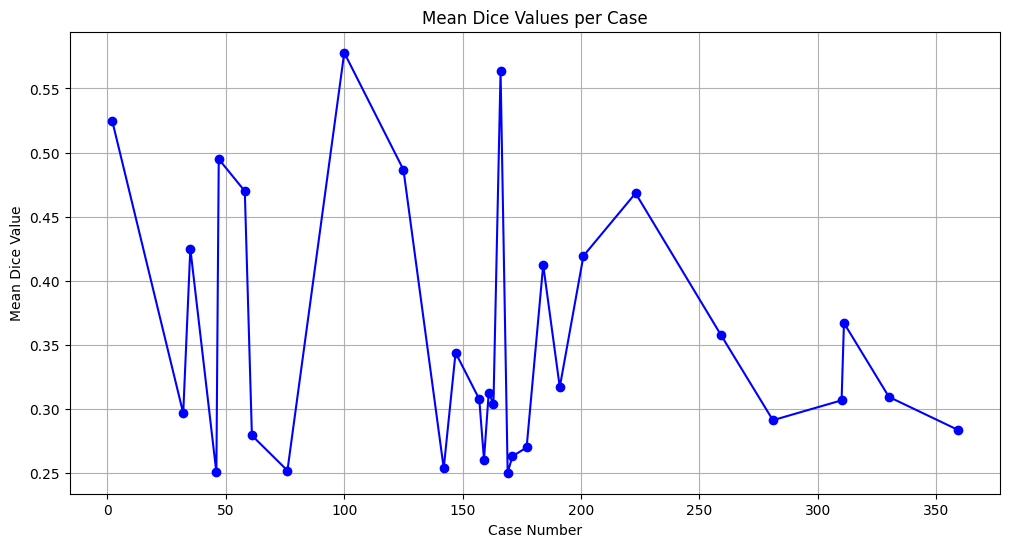

In [37]:
import matplotlib.pyplot as plt

# Function to read the log file and extract data
def read_log_file(file_path):
    case_numbers = []
    mean_dice_values = []
    with open(file_path, 'r') as file:
        for line in file:
            if 'mean_dice' in line and 'case' in line:
                parts = line.split()
                case_number = int(parts[4])
                mean_dice_value = float(parts[6])
                case_numbers.append(case_number)
                mean_dice_values.append(mean_dice_value)
    return case_numbers, mean_dice_values

# Define the file path
file_path = '/content/testing_log/content_log.txt'

# Read the log file and extract data
case_numbers, mean_dice_values = read_log_file(file_path)

# Plotting the mean_dice values
plt.figure(figsize=(12, 6))
plt.plot(case_numbers, mean_dice_values, marker='o', linestyle='-', color='b')
plt.title('Mean Dice Values per Case')
plt.xlabel('Case Number')
plt.ylabel('Mean Dice Value')
plt.grid(True)
plt.show()


args
    -> root_path': '/content/data'
    
    -> output': '/content/output'
    
    -> num_classes': 1+3
    
    -> batch_size': 12
    
    -> n_gpu': 1
    
    -> base_lr': 0.0001
    
    -> max_epochs': 20
    
    -> stop_epoch': 20
    
    -> deterministic': 1
    
    -> img_size': 240
    
    -> seed': 1234
    
    -> vit_name': 'vit_b'
    
    -> ckpt': '/content/drive/MyDrive/dataset_brats/->
    am_vit_b_01ec64.pth'
    
    -> adapt_ckpt': None
    
    -> rank': 32
    
    -> scale': 1.0
    
    -> warmup': True
    
    -> warmup_period': 100
    
    -> AdamW': True
    
    -> module': 'sam_fact_tt_image_encoder'
    
    -> dice_param': 0.8
    
    -> lr_exp': 7
    
    -> tf32': True
    
    -> compile': False
    
    -> use_amp': True
    
    -> skip_hard': Tru
    


In [ ]:
!python /content/drive/MyDrive/dataset_brats/MA-SAM-main/MA-SAM/test.py --adapt_ckpt /content/output/epoch_19.pth --data_path /content/data --vit_name vit_b --ckpt /content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth --is_savenii


Namespace(adapt_ckpt='/content/output/epoch_19.pth', data_path='/content/data', num_classes=4, img_size=240, seed=1234, is_savenii=True, deterministic=1, ckpt='/content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth', vit_name='vit_b', rank=32, scale=1.0, module='sam_fact_tt_image_encoder', output_dir='/content/output/epoch_19')
  0% 0/10 [00:00<?, ?it/s]idx 1 case 015 mean_dice 0.453334
 10% 1/10 [00:11<01:41, 11.28s/it]idx 1 case 052 mean_dice 0.372251
 20% 2/10 [00:21<01:24, 10.62s/it]idx 1 case 060 mean_dice 0.494759
 30% 3/10 [00:31<01:13, 10.44s/it]idx 1 case 068 mean_dice 0.374936
 40% 4/10 [00:41<01:01, 10.30s/it]idx 1 case 076 mean_dice 0.286775
 50% 5/10 [00:51<00:51, 10.22s/it]idx 1 case 088 mean_dice 0.355366
 60% 6/10 [01:01<00:40, 10.17s/it]idx 1 case 144 mean_dice 0.296803
 70% 7/10 [01:11<00:30, 10.13s/it]idx 1 case 252 mean_dice 0.331478
 80% 8/10 [01:22<00:20, 10.11s/it]idx 1 case 265 mean_dice 0.415770
 90% 9/10 [01:32<00:10, 10.12s/it]idx 1 case 331 mean_dice 0.31

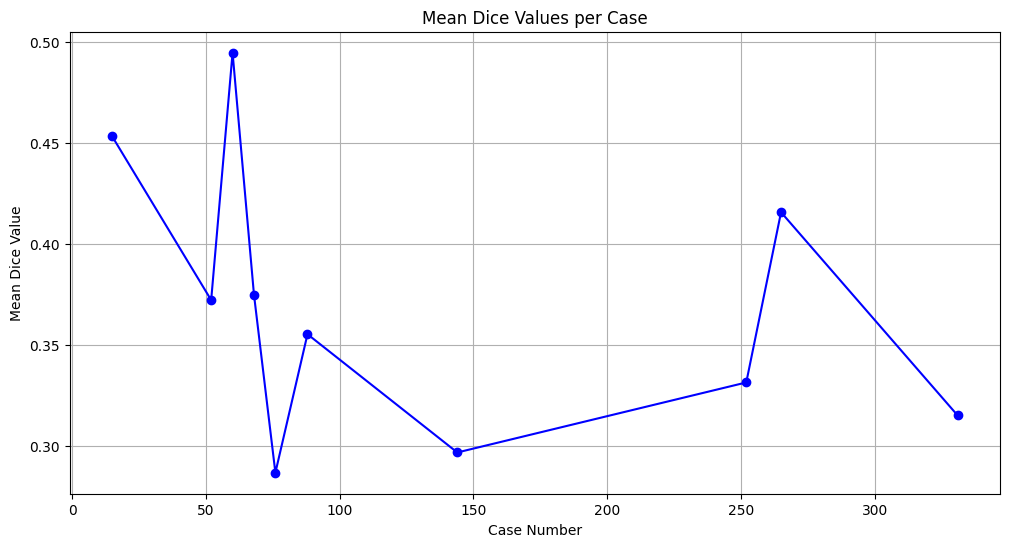

In [ ]:
import matplotlib.pyplot as plt

# Function to read the log file and extract data
def read_log_file(file_path):
    case_numbers = []
    mean_dice_values = []
    with open(file_path, 'r') as file:
        for line in file:
            if 'mean_dice' in line and 'case' in line:
                parts = line.split()
                case_number = int(parts[4])
                mean_dice_value = float(parts[6])
                case_numbers.append(case_number)
                mean_dice_values.append(mean_dice_value)
    return case_numbers, mean_dice_values

# Define the file path
file_path = '/content/testing_log/content_log.txt'

# Read the log file and extract data
case_numbers, mean_dice_values = read_log_file(file_path)

# Plotting the mean_dice values
plt.figure(figsize=(12, 6))
plt.plot(case_numbers, mean_dice_values, marker='o', linestyle='-', color='b')
plt.title('Mean Dice Values per Case')
plt.xlabel('Case Number')
plt.ylabel('Mean Dice Value')
plt.grid(True)
plt.show()

args
    - root_path': '/content/data',
    
    - output': '/content/output',
    
    - num_classes': 1+3,
    
    - batch_size': 12,
    
    - n_gpu': 1,
    
    - base_lr': 0.00001,
    
    - max_epochs': 10,
    
    - stop_epoch': 10,
    
    - deterministic': 1,
    
    - img_size': 240,
    
    - seed': 1234,
    
    - vit_name': 'vit_b',
    
    - ckpt': '/content/drive/MyDrive/dataset_brats/
    
    - sam_vit_b_01ec64.pth',
    
    - adapt_ckpt': None,
    
    - rank': 32,
    
    - scale': 1.0,
    
    - warmup': True,
    
    - warmup_period': 100,
    
    - AdamW': True,
    
    - module': 'sam_fact_tt_image_encoder',
    
    - dice_param': 0.8,
    
    - lr_exp': 7,
    
    - tf32': True,
    
    - compile': False,
    
    - use_amp': True,

    - skip_hard': True


In [ ]:
!python /content/drive/MyDrive/dataset_brats/MA-SAM-main/MA-SAM/test.py --adapt_ckpt /content/output/epoch_9.pth --data_path /content/data --vit_name vit_b --ckpt /content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth --is_savenii


Namespace(adapt_ckpt='/content/output/epoch_9.pth', data_path='/content/data', num_classes=4, img_size=240, seed=1234, is_savenii=True, deterministic=1, ckpt='/content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth', vit_name='vit_b', rank=32, scale=1.0, module='sam_fact_tt_image_encoder', output_dir='/content/output/epoch_9')
  0% 0/10 [00:00<?, ?it/s]idx 1 case 060 mean_dice 0.005628
 10% 1/10 [00:11<01:45, 11.74s/it]idx 1 case 065 mean_dice 0.008544
 20% 2/10 [00:22<01:28, 11.08s/it]idx 1 case 121 mean_dice 0.009893
 30% 3/10 [00:32<01:15, 10.78s/it]idx 1 case 179 mean_dice 0.007808
 40% 4/10 [00:43<01:03, 10.66s/it]idx 1 case 212 mean_dice 0.011242
 50% 5/10 [00:53<00:52, 10.59s/it]idx 1 case 251 mean_dice 0.002822
 60% 6/10 [01:04<00:42, 10.53s/it]idx 1 case 267 mean_dice 0.000645
 70% 7/10 [01:14<00:31, 10.49s/it]idx 1 case 274 mean_dice 0.003312
 80% 8/10 [01:24<00:20, 10.48s/it]idx 1 case 311 mean_dice 0.000060
 90% 9/10 [01:35<00:10, 10.47s/it]idx 1 case 338 mean_dice 0.0132

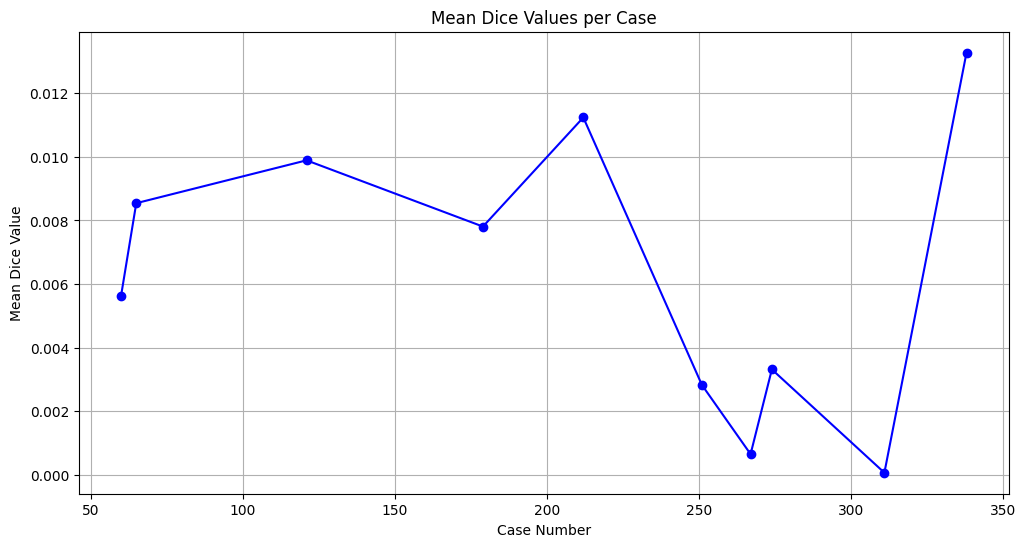

In [ ]:
import matplotlib.pyplot as plt

# Function to read the log file and extract data
def read_log_file(file_path):
    case_numbers = []
    mean_dice_values = []
    with open(file_path, 'r') as file:
        for line in file:
            if 'mean_dice' in line and 'case' in line:
                parts = line.split()
                case_number = int(parts[4])
                mean_dice_value = float(parts[6])
                case_numbers.append(case_number)
                mean_dice_values.append(mean_dice_value)
    return case_numbers, mean_dice_values

# Define the file path
file_path = '/content/testing_log/content_log.txt'

# Read the log file and extract data
case_numbers, mean_dice_values = read_log_file(file_path)

# Plotting the mean_dice values
plt.figure(figsize=(12, 6))
plt.plot(case_numbers, mean_dice_values, marker='o', linestyle='-', color='b')
plt.title('Mean Dice Values per Case')
plt.xlabel('Case Number')
plt.ylabel('Mean Dice Value')
plt.grid(True)
plt.show()

args =
   - root_path': '/content/data',
   - output': '/content/output',
   - num_classes': 1+3,
   - batch_size': 12,
   - n_gpu': 1,
   - base_lr': 0.0001,
   - max_epochs': 5,
   - stop_epoch': 5,
   - deterministic': 1,
   - img_size': 240,
   - seed': 1234,
   - vit_name': 'vit_b',
   - ckpt': '/content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth',
   - adapt_ckpt': None,
   - rank': 32,
   - scale': 1.0,
   - warmup': True,
   - warmup_period': 100,
   - AdamW': True,
   - module': 'sam_fact_tt_image_encoder',
   - dice_param': 0.8,
   - lr_exp': 7,
   - tf32': True,
   - compile': False,
   - use_amp': True,
   - skip_hard': True

In [ ]:
!python /content/drive/MyDrive/dataset_brats/MA-SAM-main/MA-SAM/test.py --adapt_ckpt /content/output/epoch_4.pth --data_path /content/data --vit_name vit_b --ckpt /content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth --is_savenii


Namespace(adapt_ckpt='/content/output/epoch_4.pth', data_path='/content/data', num_classes=4, img_size=240, seed=1234, is_savenii=True, deterministic=1, ckpt='/content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth', vit_name='vit_b', rank=32, scale=1.0, module='sam_fact_tt_image_encoder', output_dir='/content/output/epoch_4')
  0% 0/10 [00:00<?, ?it/s]idx 1 case 101 mean_dice 0.361989
 10% 1/10 [00:11<01:40, 11.15s/it]idx 1 case 114 mean_dice 0.297617
 20% 2/10 [00:21<01:23, 10.49s/it]idx 1 case 116 mean_dice 0.296451
 30% 3/10 [00:31<01:11, 10.28s/it]idx 1 case 123 mean_dice 0.354548
 40% 4/10 [00:41<01:01, 10.24s/it]idx 1 case 138 mean_dice 0.310810
 50% 5/10 [00:51<00:50, 10.14s/it]idx 1 case 218 mean_dice 0.290474
 60% 6/10 [01:01<00:40, 10.08s/it]idx 1 case 224 mean_dice 0.326507
 70% 7/10 [01:11<00:30, 10.07s/it]idx 1 case 261 mean_dice 0.315820
 80% 8/10 [01:21<00:20, 10.04s/it]idx 1 case 263 mean_dice 0.506110
 90% 9/10 [01:31<00:10, 10.03s/it]idx 1 case 364 mean_dice 0.2640

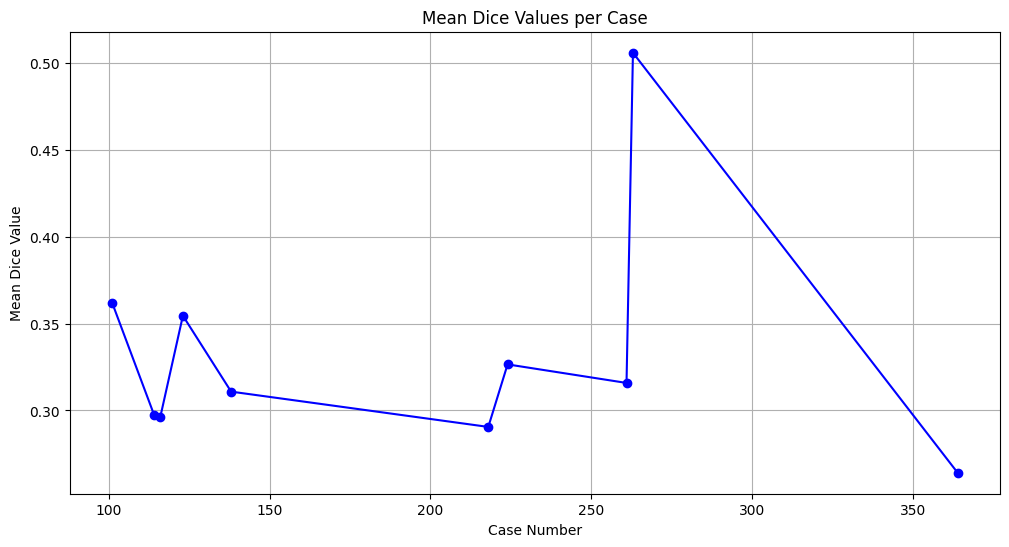

In [ ]:
import matplotlib.pyplot as plt

# Function to read the log file and extract data
def read_log_file(file_path):
    case_numbers = []
    mean_dice_values = []
    with open(file_path, 'r') as file:
        for line in file:
            if 'mean_dice' in line and 'case' in line:
                parts = line.split()
                case_number = int(parts[4])
                mean_dice_value = float(parts[6])
                case_numbers.append(case_number)
                mean_dice_values.append(mean_dice_value)
    return case_numbers, mean_dice_values

# Define the file path
file_path = '/content/testing_log/content_log.txt'

# Read the log file and extract data
case_numbers, mean_dice_values = read_log_file(file_path)

# Plotting the mean_dice values
plt.figure(figsize=(12, 6))
plt.plot(case_numbers, mean_dice_values, marker='o', linestyle='-', color='b')
plt.title('Mean Dice Values per Case')
plt.xlabel('Case Number')
plt.ylabel('Mean Dice Value')
plt.grid(True)
plt.show()

In [ ]:
!python /content/drive/MyDrive/dataset_brats/MA-SAM-main/MA-SAM/test.py --adapt_ckpt /content/output/epoch_4.pth --data_path /content/data --vit_name vit_b --ckpt /content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth --is_savenii


Namespace(adapt_ckpt='/content/output/epoch_4.pth', data_path='/content/data', num_classes=4, img_size=240, seed=1234, is_savenii=True, deterministic=1, ckpt='/content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth', vit_name='vit_b', rank=32, scale=1.0, module='sam_fact_tt_image_encoder', output_dir='/content/output/epoch_4')
  0% 0/10 [00:00<?, ?it/s]idx 1 case 110 mean_dice 0.250962
 10% 1/10 [00:11<01:39, 11.00s/it]idx 1 case 135 mean_dice 0.308653
 20% 2/10 [00:21<01:23, 10.49s/it]idx 1 case 138 mean_dice 0.345188
 30% 3/10 [00:31<01:11, 10.25s/it]idx 1 case 149 mean_dice 0.351523
 40% 4/10 [00:41<01:01, 10.17s/it]idx 1 case 231 mean_dice 0.109708
 50% 5/10 [00:51<00:50, 10.11s/it]idx 1 case 250 mean_dice 0.262203
 60% 6/10 [01:01<00:40, 10.07s/it]idx 1 case 259 mean_dice 0.341781
 70% 7/10 [01:11<00:30, 10.03s/it]idx 1 case 301 mean_dice 0.316428
 80% 8/10 [01:21<00:20, 10.02s/it]idx 1 case 308 mean_dice 0.319675
 90% 9/10 [01:31<00:10, 10.01s/it]idx 1 case 321 mean_dice 0.5026

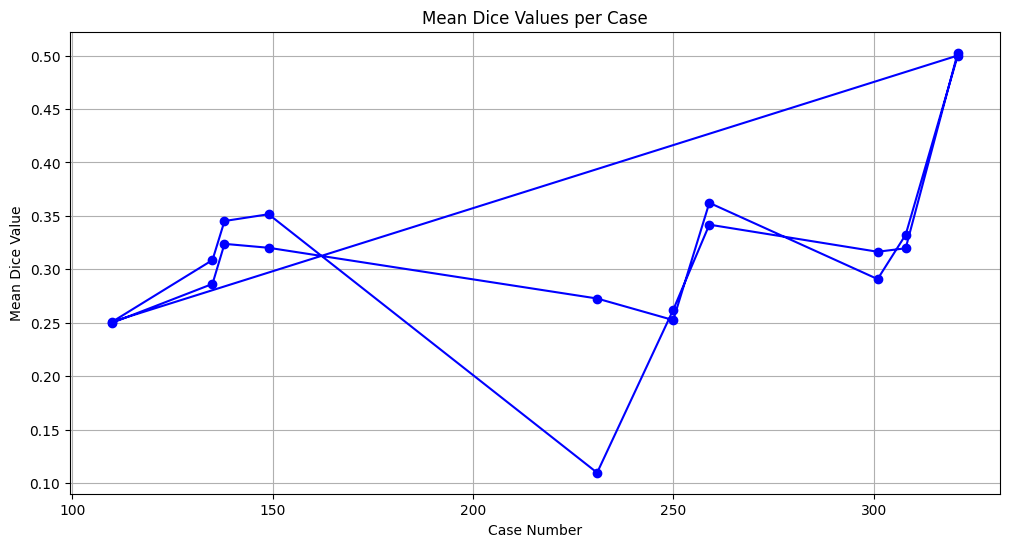

In [ ]:
import matplotlib.pyplot as plt

# Function to read the log file and extract data
def read_log_file(file_path):
    case_numbers = []
    mean_dice_values = []
    with open(file_path, 'r') as file:
        for line in file:
            if 'mean_dice' in line and 'case' in line:
                parts = line.split()
                case_number = int(parts[4])
                mean_dice_value = float(parts[6])
                case_numbers.append(case_number)
                mean_dice_values.append(mean_dice_value)
    return case_numbers, mean_dice_values

# Define the file path
file_path = '/content/testing_log/content_log.txt'

# Read the log file and extract data
case_numbers, mean_dice_values = read_log_file(file_path)

# Plotting the mean_dice values
plt.figure(figsize=(12, 6))
plt.plot(case_numbers, mean_dice_values, marker='o', linestyle='-', color='b')
plt.title('Mean Dice Values per Case')
plt.xlabel('Case Number')
plt.ylabel('Mean Dice Value')
plt.grid(True)
plt.show()

In [ ]:
!python /content/drive/MyDrive/dataset_brats/MA-SAM-main/MA-SAM/test.py --adapt_ckpt /content/output/epoch_4.pth --data_path /content/data --vit_name vit_b --ckpt /content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth --is_savenii



test_size = 10
val_size = 5
train_size = 35


args =
    -> root_path': '/content/data',

    -> output': '/content/output',

    -> num_classes': 1+3,

    -> batch_size': 12,

    -> n_gpu': 1,

    -> base_lr': 0.001,

    -> max_epochs': 5,

    -> stop_epoch': 5,

    -> deterministic': 1,

    -> img_size': 240,

    -> seed': 1234,

    -> vit_name': 'vit_b',

    -> ckpt': '/content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth',

    -> adapt_ckpt': None,

    -> rank': 32,

    -> scale': 1.0,

    -> warmup': True,

    -> warmup_period': 100,

    -> AdamW': True,

    -> module': 'sam_fact_tt_image_encoder',

    -> dice_param': 0.8,

    -> lr_exp': 7,

    -> tf32': True,

    -> compile': False,

    -> use_amp': True,

    -> skip_hard': True



In [ ]:
!python /content/drive/MyDrive/dataset_brats/MA-SAM-main/MA-SAM/test.py --adapt_ckpt /content/output/epoch_4.pth --data_path /content/data --vit_name vit_b --ckpt /content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth --is_savenii


Namespace(adapt_ckpt='/content/output/epoch_4.pth', data_path='/content/data', num_classes=4, img_size=240, seed=1234, is_savenii=True, deterministic=1, ckpt='/content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth', vit_name='vit_b', rank=32, scale=1.0, module='sam_fact_tt_image_encoder', output_dir='/content/output/epoch_4')
  0% 0/10 [00:00<?, ?it/s]idx 1 case 110 mean_dice 0.250000
 10% 1/10 [00:11<01:42, 11.36s/it]idx 1 case 135 mean_dice 0.286336
 20% 2/10 [00:21<01:25, 10.65s/it]idx 1 case 138 mean_dice 0.323819
 30% 3/10 [00:31<01:12, 10.36s/it]idx 1 case 149 mean_dice 0.320146
 40% 4/10 [00:41<01:01, 10.24s/it]idx 1 case 231 mean_dice 0.272678
 50% 5/10 [00:51<00:50, 10.19s/it]idx 1 case 250 mean_dice 0.252494
 60% 6/10 [01:01<00:40, 10.13s/it]idx 1 case 259 mean_dice 0.362196
 70% 7/10 [01:11<00:30, 10.07s/it]idx 1 case 301 mean_dice 0.290856
 80% 8/10 [01:21<00:20, 10.05s/it]idx 1 case 308 mean_dice 0.332333
 90% 9/10 [01:31<00:10, 10.05s/it]idx 1 case 321 mean_dice 0.5000

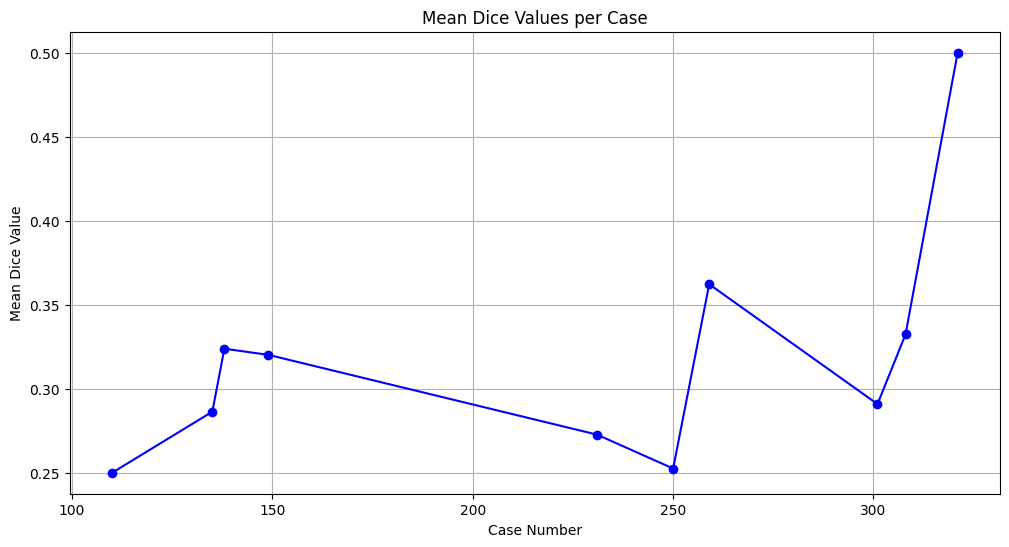

In [ ]:
import matplotlib.pyplot as plt

# Function to read the log file and extract data
def read_log_file(file_path):
    case_numbers = []
    mean_dice_values = []
    with open(file_path, 'r') as file:
        for line in file:
            if 'mean_dice' in line and 'case' in line:
                parts = line.split()
                case_number = int(parts[4])
                mean_dice_value = float(parts[6])
                case_numbers.append(case_number)
                mean_dice_values.append(mean_dice_value)
    return case_numbers, mean_dice_values

# Define the file path
file_path = '/content/testing_log/content_log.txt'

# Read the log file and extract data
case_numbers, mean_dice_values = read_log_file(file_path)

# Plotting the mean_dice values
plt.figure(figsize=(12, 6))
plt.plot(case_numbers, mean_dice_values, marker='o', linestyle='-', color='b')
plt.title('Mean Dice Values per Case')
plt.xlabel('Case Number')
plt.ylabel('Mean Dice Value')
plt.grid(True)
plt.show()

In [ ]:
pip install segment-anything


deneme sonuçlarında kullanılan materyaller
args =
-> root_path': '/content/data',

-> output': '/content/output',

-> num_classes': 1+3,

-> batch_size': 12,

-> n_gpu': 1,

-> base_lr': 0.001,

-> max_epochs': 10,

-> stop_epoch': 10,

-> deterministic': 1,

-> img_size': 240,

-> seed': 1234,

-> vit_name': 'vit_b',

-> ckpt': '/content/drive/MyDrive/dataset_brat->  
am_vit_b_01ec64.pth',

-> adapt_ckpt': None,

-> rank': 32,

-> scale': 1.0,

-> warmup': True,

-> warmup_period': 100,

-> AdamW': True,

-> module': 'sam_fact_tt_image_encoder',

-> dice_param': 0.8,

-> lr_exp': 7,

-> tf32': True,

-> compile': False,

-> use_amp': True,

-> skip_hard': True



In [ ]:
# batch size 12 / 10 epoch
# test_size = 20
# val_size = 10
# train_size = 50

!python /content/drive/MyDrive/dataset_brats/MA-SAM-main/MA-SAM/test.py --adapt_ckpt /content/output/epoch_9.pth --data_path /content/data --vit_name vit_b --ckpt /content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth --is_savenii


Namespace(adapt_ckpt='/content/output/epoch_9.pth', data_path='/content/data', num_classes=4, img_size=240, seed=1234, is_savenii=True, deterministic=1, ckpt='/content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth', vit_name='vit_b', rank=32, scale=1.0, module='sam_fact_tt_image_encoder', output_dir='/content/output/epoch_9')
  0% 0/20 [00:00<?, ?it/s]idx 1 case 012 mean_dice 0.250000
  5% 1/20 [00:10<03:25, 10.81s/it]idx 1 case 017 mean_dice 0.250000
 10% 2/20 [00:20<03:06, 10.39s/it]idx 1 case 048 mean_dice 0.250000
 15% 3/20 [00:31<02:55, 10.31s/it]idx 1 case 072 mean_dice 0.250000
 20% 4/20 [00:41<02:45, 10.33s/it]idx 1 case 073 mean_dice 0.250000
 25% 5/20 [00:51<02:33, 10.24s/it]idx 1 case 084 mean_dice 0.250000
 30% 6/20 [01:01<02:22, 10.19s/it]idx 1 case 119 mean_dice 0.250000
 35% 7/20 [01:11<02:12, 10.16s/it]idx 1 case 130 mean_dice 0.250000
 40% 8/20 [01:21<02:01, 10.16s/it]idx 1 case 165 mean_dice 0.250000
 45% 9/20 [01:32<01:51, 10.14s/it]idx 1 case 221 mean_dice 0.2500

-> test_size = 20

-> val_size = 10

-> train_size = 70


args
    -> root_path': '/content/data',
    
    -> output': '/content/output',
    
    -> num_classes': 1+3,
    
    -> batch_size': 12,
    
    -> n_gpu': 1,
    
    -> base_lr': 0.001,
    
    -> max_epochs': 10,
    
    -> stop_epoch': 10,
    
    -> deterministic': 1,
    
    -> img_size': 240,
    
    -> seed': 1234,
    
    -> vit_name': 'vit_b',
    
    -> ckpt': '/content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth',
    
    -> adapt_ckpt': None,
    
    -> rank': 32,
    
    -> scale': 1.0,
    
    -> warmup': True,
    
    -> warmup_period': 100,
    
    -> AdamW': True,
    
    -> module': 'sam_fact_tt_image_encoder',
    
    -> dice_param': 0.8,
    
    -> lr_exp': 7,
    
    -> tf32': True,
    
    -> compile': False,
    
    -> use_amp': True,
    
    -> skip_hard': True
    


In [ ]:
!python /content/drive/MyDrive/dataset_brats/MA-SAM-main/MA-SAM/test.py --adapt_ckpt /content/output/epoch_9.pth --data_path /content/data --vit_name vit_b --ckpt /content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth --is_savenii


Namespace(adapt_ckpt='/content/output/epoch_9.pth', data_path='/content/data', num_classes=4, img_size=240, seed=1234, is_savenii=True, deterministic=1, ckpt='/content/drive/MyDrive/dataset_brats/sam_vit_b_01ec64.pth', vit_name='vit_b', rank=32, scale=1.0, module='sam_fact_tt_image_encoder', output_dir='/content/output/epoch_9')
  0% 0/20 [00:00<?, ?it/s]idx 1 case 019 mean_dice 0.256043
  5% 1/20 [00:14<04:32, 14.32s/it]idx 1 case 027 mean_dice 0.258627
 10% 2/20 [00:27<04:01, 13.42s/it]idx 1 case 062 mean_dice 0.282771
 15% 3/20 [00:40<03:44, 13.19s/it]idx 1 case 080 mean_dice 0.259588
 20% 4/20 [00:52<03:28, 13.04s/it]idx 1 case 095 mean_dice 0.267957
 25% 5/20 [01:05<03:15, 13.02s/it]idx 1 case 103 mean_dice 0.250533
 30% 6/20 [01:19<03:03, 13.09s/it]idx 1 case 123 mean_dice 0.271692
 35% 7/20 [01:32<02:51, 13.19s/it]idx 1 case 133 mean_dice 0.255773
 40% 8/20 [01:45<02:39, 13.28s/it]idx 1 case 147 mean_dice 0.254211
 45% 9/20 [01:59<02:25, 13.25s/it]idx 1 case 173 mean_dice 0.2594

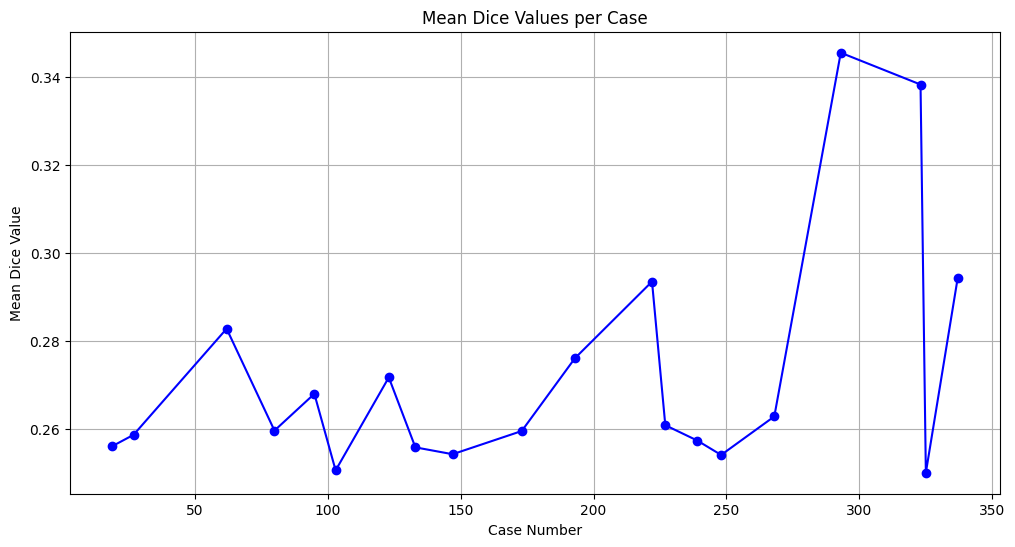

In [ ]:
import matplotlib.pyplot as plt

# Function to read the log file and extract data
def read_log_file(file_path):
    case_numbers = []
    mean_dice_values = []
    with open(file_path, 'r') as file:
        for line in file:
            if 'mean_dice' in line and 'case' in line:
                parts = line.split()
                case_number = int(parts[4])
                mean_dice_value = float(parts[6])
                case_numbers.append(case_number)
                mean_dice_values.append(mean_dice_value)
    return case_numbers, mean_dice_values

# Define the file path
file_path = '/content/testing_log/content_log.txt'

# Read the log file and extract data
case_numbers, mean_dice_values = read_log_file(file_path)

# Plotting the mean_dice values
plt.figure(figsize=(12, 6))
plt.plot(case_numbers, mean_dice_values, marker='o', linestyle='-', color='b')
plt.title('Mean Dice Values per Case')
plt.xlabel('Case Number')
plt.ylabel('Mean Dice Value')
plt.grid(True)
plt.show()
